In [273]:
import pandas as pd
import numpy as np 
from math import *

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from colorama import Fore, Style

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from functools import partial
import optuna
from optuna.integration import LightGBMPruningCallback

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss, brier_score_loss, mean_squared_error, cohen_kappa_score, matthews_corrcoef
from sklearn.calibration import calibration_curve
import joblib 

# Step 1 : Load and Explore Data

In [274]:
df = pd.read_csv('data/datasets/credit_risk_dataset.csv')
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [275]:
df.loc[0]

person_age                          22
person_income                    59000
person_home_ownership             RENT
person_emp_length                123.0
loan_intent                   PERSONAL
loan_grade                           D
loan_amnt                        35000
loan_int_rate                    16.02
loan_status                          1
loan_percent_income               0.59
cb_person_default_on_file            Y
cb_person_cred_hist_length           3
Name: 0, dtype: object

In [276]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [278]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
person_income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
person_home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_int_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


# Step 2 : Data Preprocessing

In [279]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [280]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [281]:
df.duplicated().sum()

np.int64(165)

In [282]:
df = df.dropna().reset_index(drop=True) # can't allow not to know criticial account information

In [283]:
df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [284]:
df = df[df['person_emp_length'] < 60].reset_index(drop=True)

In [285]:
df = df.rename(columns={'person_age': 'age', 'person_income': 'income', 'person_home_ownership' : 'home_ownership', 'person_emp_length': 'employment_length', 'loan_intent': 'purpose', 'loan_grade' : 'grade', 'loan_amnt': 'amount', 'loan_int_rate': 'interest_rate', 'loan_status': 'status', 'loan_percent_income' : 'percent_income', 'cb_person_default_on_file': 'default', 'cb_person_cred_hist_length': 'credit_history_length'})

In [286]:
df

,age,income,home_ownership,employment_length,purpose,grade,amount,interest_rate,status,percent_income,default,credit_history_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
28631,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
28632,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
28633,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
28634,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [287]:
df.columns

Index(['age', 'income', 'home_ownership', 'employment_length', 'purpose',
       'grade', 'amount', 'interest_rate', 'status', 'percent_income',
       'default', 'credit_history_length'],
      dtype='object')

In [288]:
df['purpose'].value_counts()

purpose
EDUCATION            5704
MEDICAL              5293
VENTURE              5000
PERSONAL             4876
DEBTCONSOLIDATION    4565
HOMEIMPROVEMENT      3198
Name: count, dtype: int64

In [289]:
df['home_ownership'].value_counts()

home_ownership
RENT        14550
MORTGAGE    11800
OWN          2192
OTHER          94
Name: count, dtype: int64

In [290]:
df['status'].value_counts()

status
0    22434
1     6202
Name: count, dtype: int64

# Step 3: Data Visualization

In [291]:
continuous_features = ['age', 'income', 'employment_length',
                       'amount', 'interest_rate', 'percent_income', 
                       'credit_history_length']
n_plot_features = len(continuous_features)

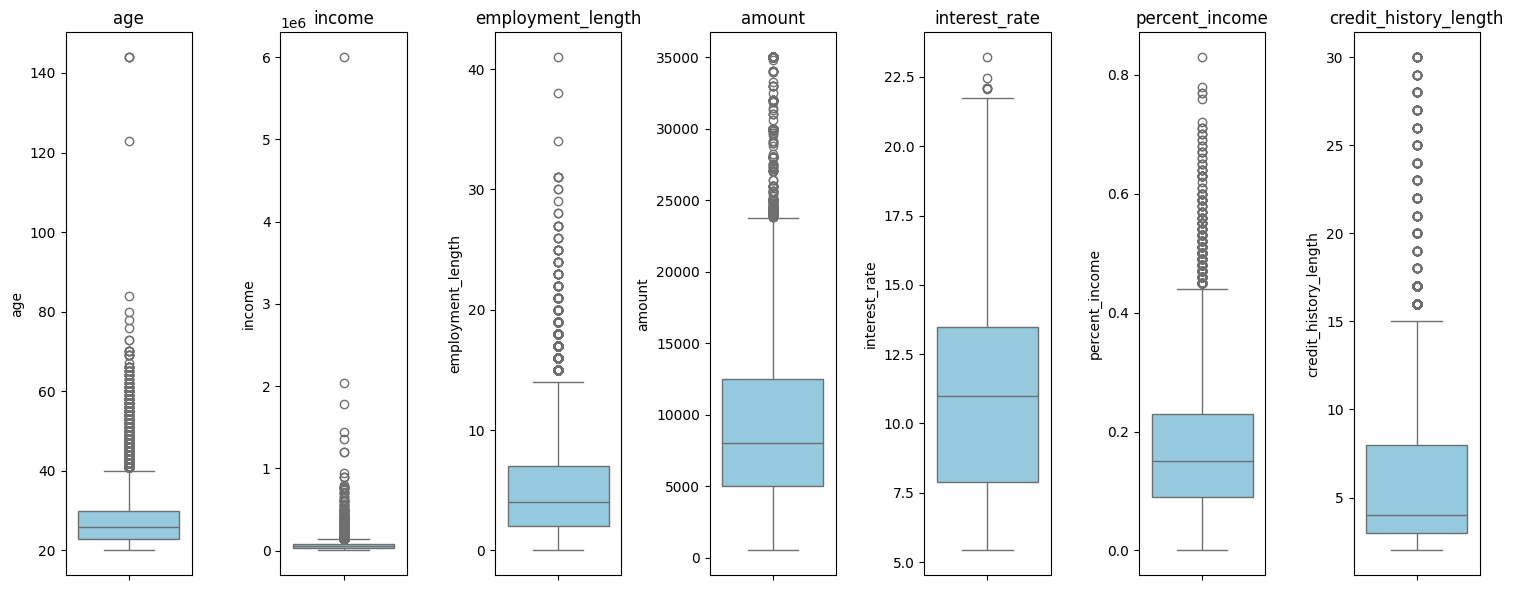

In [292]:
plt.figure(figsize=(15,6))
for i, col in enumerate(continuous_features):
    plt.subplot(1, n_plot_features, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

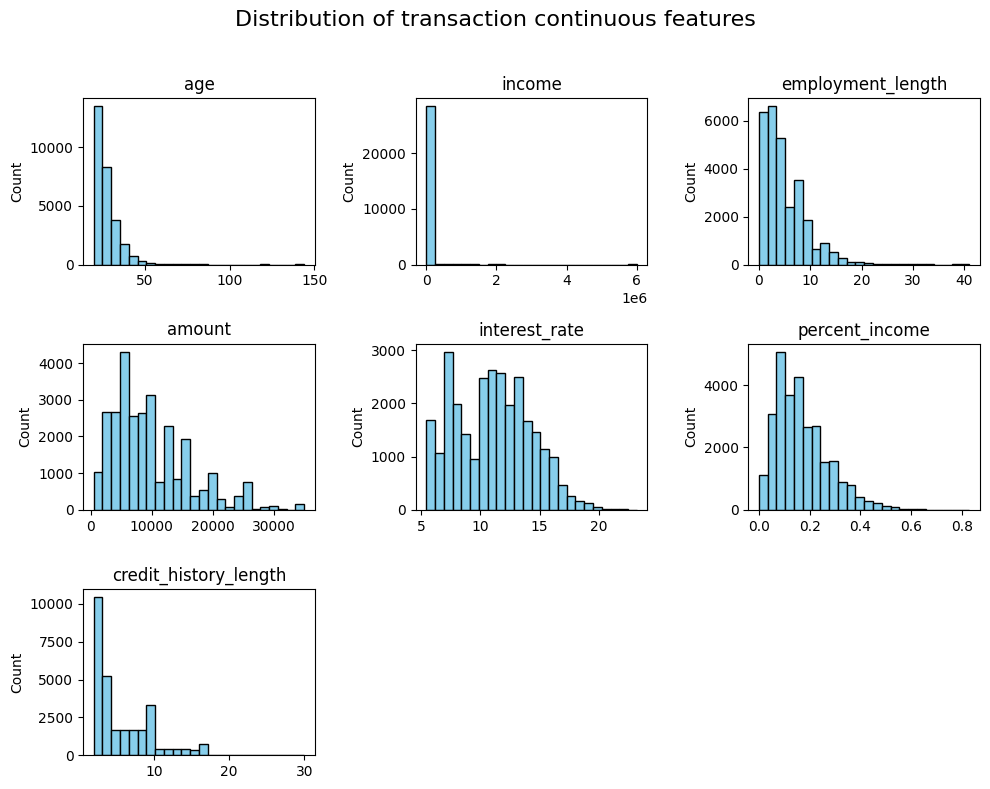

In [293]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(continuous_features):
    axes[i].hist(df[col], bins=24, edgecolor='black', color='skyblue')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.suptitle("Distribution of transaction continuous features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [294]:
categorical_features = ['home_ownership', 'purpose', 'grade', 'status']

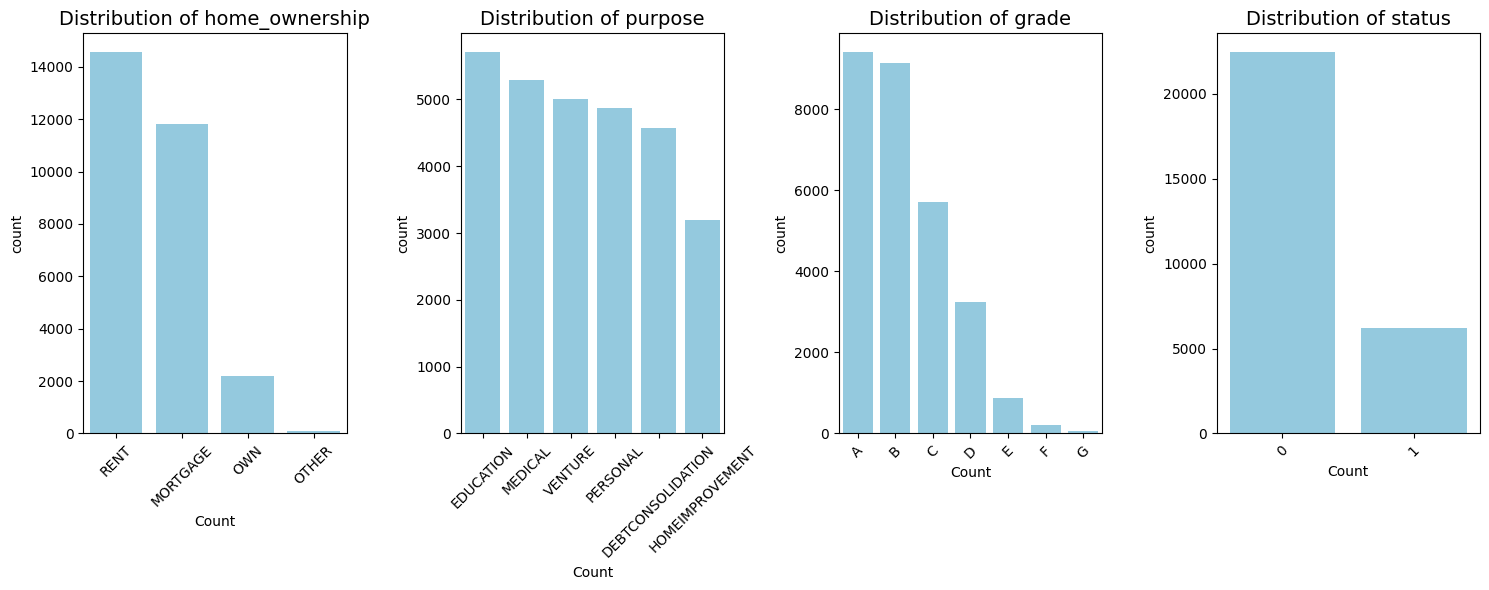

In [295]:
plt.figure(figsize=(15,6))
for i, col in enumerate(categorical_features):
    ax = plt.subplot(1, 4, i+1)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, color='skyblue', order=order, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=14)
    ax.set_xlabel('Count')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [296]:
df.groupby('home_ownership')['amount'].mean()

home_ownership
MORTGAGE    10634.961864
OTHER       11128.989362
OWN          9130.748175
RENT         8930.197595
Name: amount, dtype: float64

In [297]:
df.groupby('purpose')['amount'].mean()

purpose
DEBTCONSOLIDATION     9664.824754
EDUCATION             9521.252630
HOMEIMPROVEMENT      10407.059099
MEDICAL               9344.147931
PERSONAL              9660.444011
VENTURE               9642.765000
Name: amount, dtype: float64

In [298]:
df.groupby('credit_history_length')['amount'].mean()

credit_history_length
2      9272.219564
3      9368.764335
4      9379.094127
5     10115.798193
6     10017.163725
7      9859.219964
8     10020.930931
9      9837.740385
10    10197.125382
11    10493.048780
12     9727.816901
13     9918.992248
14    10114.850917
15    10357.364865
16    10108.397933
17    10132.564841
18     8375.000000
19    14975.000000
20    12093.965517
21    10275.000000
22     8732.142857
23    11756.578947
24     7871.296296
25     9900.000000
26     8768.750000
27    11086.111111
28    10426.136364
29     8295.454545
30    10611.842105
Name: amount, dtype: float64

In [299]:
df.pivot_table(values='amount', index='home_ownership', columns='purpose')

purpose,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
home_ownership,,,,,,
MORTGAGE,10576.078869,10569.771453,10832.364341,10689.176346,10498.972437,10708.030691
OTHER,9928.571429,11028.571429,11322.727273,11116.071429,12981.250000,10594.000000
OWN,8710.887097,8839.932886,9495.357143,9633.424658,9175.065617,8907.876712
RENT,8944.389406,8786.619357,10103.035320,8457.433775,8995.873082,8955.691917


In [300]:
df['default'].value_counts(normalize=True) * 100

default
N    82.183266
Y    17.816734
Name: proportion, dtype: float64

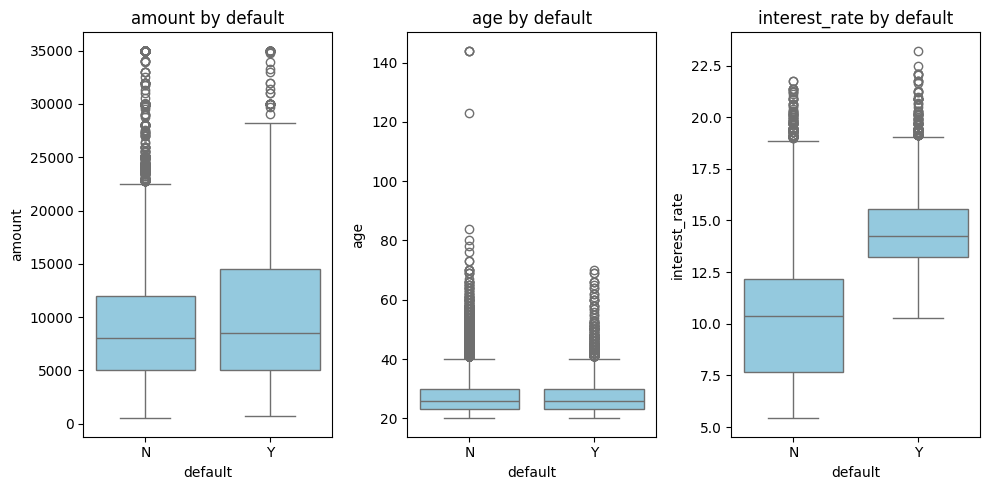

In [301]:
plt.figure(figsize=(10,5))
for i, col in enumerate(['amount', 'age', 'interest_rate']):
    plt.subplot(1,3, i+1)
    sns.boxplot(data=df, x='default', y=col, color='skyblue')
    plt.title(f"{col} by default")
plt.tight_layout()
plt.show()

In [302]:
df.groupby('default')[['amount', 'age', 'interest_rate']].mean()

,amount,age,interest_rate
default,,,
N,9537.212119,27.704683,10.287785
Y,10199.705998,27.833595,14.508898


# Step 4 : Feature Engineering

In [303]:
features = ['age', 'income', 'home_ownership', 'employment_length', 'purpose', 'grade', 'amount', 'interest_rate', 'status', 'percent_income', 'credit_history_length']
X = df[features]
y = df['default']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(20045, 11) (4295, 11) (4296, 11)
(20045,) (4295,) (4296,)


In [304]:
X.loc[0]

age                             21
income                        9600
home_ownership                 OWN
employment_length              5.0
purpose                  EDUCATION
grade                            B
amount                        1000
interest_rate                11.14
status                           0
percent_income                 0.1
credit_history_length            2
Name: 0, dtype: object

In [305]:
categorical_features = ['home_ownership', 'purpose', 'grade', 'status']
encoders = {}
for col in categorical_features:
    encoders[col] = LabelEncoder()
    X_train[col] = encoders[col].fit_transform(X_train[col])
    X_val[col] = encoders[col].transform(X_val[col])
    X_test[col] = encoders[col].transform(X_test[col])
    print(f"\nColumn: {col}")
    print("Original classes:", list(encoders[col].classes_))
    print("Encoded values:  ", list(range(len(encoders[col].classes_))))


Column: home_ownership
Original classes: ['MORTGAGE', 'OTHER', 'OWN', 'RENT']
Encoded values:   [0, 1, 2, 3]

Column: purpose
Original classes: ['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL', 'VENTURE']
Encoded values:   [0, 1, 2, 3, 4, 5]

Column: grade
Original classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Encoded values:   [0, 1, 2, 3, 4, 5, 6]

Column: status
Original classes: [np.int64(0), np.int64(1)]
Encoded values:   [0, 1]


In [306]:
continuous_features = ['age', 'income', 'employment_length',
                       'amount', 'interest_rate', 'percent_income', 
                       'credit_history_length']
scalers = {}
for col in continuous_features:
    print(f"\nColumn: {col}")
    print("Original ranges: from ", X_train[col].min(), " to ", X_train[col].max())
    scalers[col] = RobustScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_val[col] = scalers[col].transform(X_val[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])
    print("Scaled ranges: from ", X_train[col].min(), " to ", X_train[col].max()) 


Column: age
Original ranges: from  20  to  144
Scaled ranges: from  -0.8571428571428571  to  16.857142857142858

Column: income
Original ranges: from  4000  to  6000000
Scaled ranges: from  -1.2439024390243902  to  145.0

Column: employment_length
Original ranges: from  0.0  to  41.0
Scaled ranges: from  -0.8  to  7.4

Column: amount
Original ranges: from  500  to  35000
Scaled ranges: from  -1.0  to  3.6

Column: interest_rate
Original ranges: from  5.42  to  22.48
Scaled ranges: from  -1.0  to  2.0628366247755836

Column: percent_income
Original ranges: from  0.0  to  0.83
Scaled ranges: from  -1.0714285714285714  to  4.857142857142856

Column: credit_history_length
Original ranges: from  2  to  30
Scaled ranges: from  -0.4  to  5.2


In [307]:
target = 'default'
encoders[target] = LabelEncoder()
y_train = encoders[target].fit_transform(y_train)
y_val = encoders[target].transform(y_val)
y_test = encoders[target].transform(y_test)
print(f"\nColumn: {target}")
print("Original classes:", list(encoders[target].classes_))
print("Encoded values:  ", list(range(len(encoders[target].classes_))))
all_y_labels = np.arange(len(encoders[target].classes_))


Column: default
Original classes: ['N', 'Y']
Encoded values:   [0, 1]


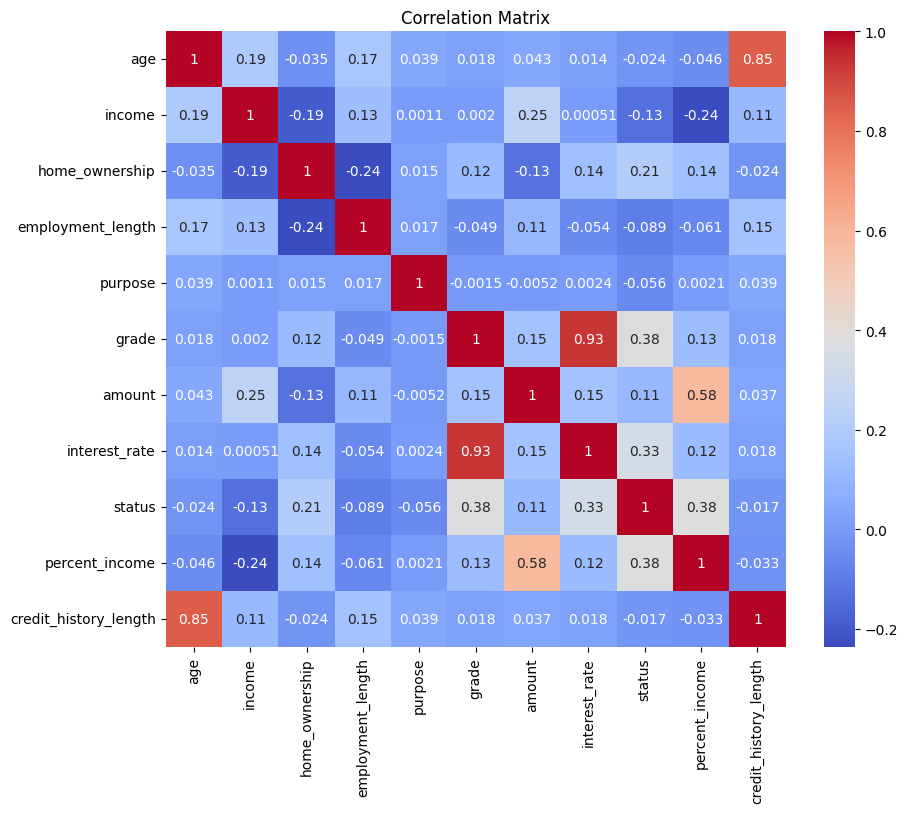

In [308]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [309]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
print("Columns to drop:", to_drop)

Columns to drop: ['interest_rate', 'credit_history_length']


In [310]:
to_drop = ['grade', 'credit_history_length']

In [311]:
X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test  = X_test.drop(columns=to_drop)

for col in to_drop:
    if col in features:
        features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)
    if col in continuous_features:
        continuous_features.remove(col)
    if col in encoders:
        encoders.pop(col)

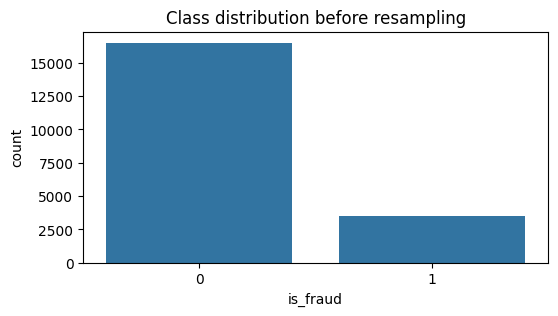

In [313]:
plt.figure(figsize=(6,3))
sns.countplot(x=y_train)
plt.xlabel("is_fraud")
plt.title("Class distribution before resampling")
plt.show()

In [314]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

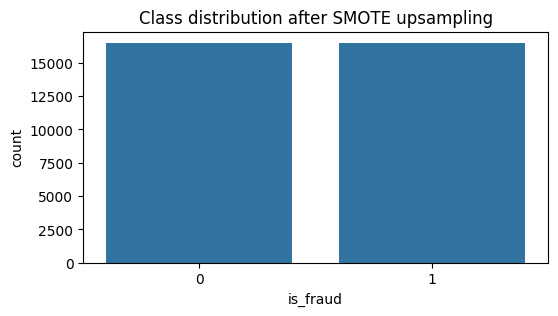

In [315]:
plt.figure(figsize=(6,3))
sns.countplot(x=y_train)
plt.xlabel("is_fraud")
plt.title("Class distribution after SMOTE upsampling")
plt.show()

In [316]:
selector_kbest = SelectKBest(score_func=f_classif, k=5)
selector_kbest.fit(X_train, y_train)

print("SelectKBest")
print("Scores:", selector_kbest.scores_)
selected_indices = np.where(selector_kbest.get_support())[0]
selected_names = X_train.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected feature names:", list(selected_names))

SelectKBest
Scores: [3.33642947e-01 5.38753760e+00 2.43279588e+02 7.06347181e+01
 3.41218009e+00 9.13661634e+01 2.65614797e+04 1.42534485e+03
 7.46087726e+01]
Selected feature indices: [2 5 6 7 8]
Selected feature names: ['home_ownership', 'amount', 'interest_rate', 'status', 'percent_income']


# Step 5 : Model training

In [317]:
def objective(trial, epochs=500, patience=50, val_margin=1e-4):
    # Hyperparameters to optimize
    params = {
        "objective": "multiclass",
        "num_class": len(all_y_labels),
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "verbosity": -1,

        # Learning dynamics
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 512),
        "max_depth": trial.suggest_int("max_depth", -1, 40),

        # Regularization 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 500),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-10, 100.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-10, 100.0, log=True),

        # Sampling / Anti-overfitting
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),  # 0 allowed

        # Binning / tree shape
        "max_bin": trial.suggest_int("max_bin", 64, 512),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 20000, 500000),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "path_smooth": trial.suggest_float("path_smooth", 0.0, 50.0),
    }

    # Train with Optuna pruning
    model = lgb.LGBMClassifier(**params, n_estimators=epochs)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[
            lgb.early_stopping(stopping_rounds=patience, first_metric_only=True, min_delta=val_margin),
            LightGBMPruningCallback(trial, metric="multi_logloss"),
        ],
    )

    # Best validation score
    preds = model.predict_proba(X_val)
    loss = log_loss(y_val, preds)
    return loss 

In [318]:
obj = partial(objective, epochs=2000, patience=200, val_margin=1e-6)
pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=50, reduction_factor=4, min_early_stopping_rate=0)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(obj, n_trials=500)

print("Best validation loss:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-11-22 01:38:58,026] A new study created in memory with name: no-name-0c3637c0-e48f-463b-91bf-07c1cbb37bdc


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:38:59,107] Trial 0 finished with value: 0.2876566194858689 and parameters: {'learning_rate': 0.06342165781153243, 'num_leaves': 61, 'max_depth': 39, 'min_data_in_leaf': 60, 'min_child_samples': 24, 'min_gain_to_split': 4.25469330443158, 'lambda_l1': 0.02573110606569981, 'lambda_l2': 1.439083157604383e-07, 'feature_fraction': 0.823977698285572, 'bagging_fraction': 0.6557371705382141, 'bagging_freq': 5, 'max_bin': 333, 'subsample_for_bin': 412036, 'extra_trees': False, 'path_smooth': 22.906438062583995}. Best is trial 0 with value: 0.2876566194858689.
[I 2025-11-22 01:38:59,237] Trial 1 pruned. Trial was pruned at iteration 50.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.287657
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:38:59,349] Trial 2 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:38:59,495] Trial 3 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:00,020] Trial 4 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:00,571] Trial 5 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:01,127] Trial 6 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:01,891] Trial 7 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:02,063] Trial 8 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:02,743] Trial 9 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:02,845] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:03,503] Trial 11 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:04,039] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:12,354] Trial 13 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:12,628] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:13,115] Trial 15 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:13,380] Trial 16 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:13,942] Trial 17 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:14,052] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:14,227] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:14,516] Trial 20 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:23,081] Trial 21 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:26,829] Trial 22 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:31,276] Trial 23 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:32,907] Trial 24 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:33,605] Trial 25 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:39:33,716] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:34,987] Trial 27 finished with value: 0.28801837682591763 and parameters: {'learning_rate': 0.14991328992688027, 'num_leaves': 448, 'max_depth': 22, 'min_data_in_leaf': 41, 'min_child_samples': 18, 'min_gain_to_split': 0.67996881136408, 'lambda_l1': 0.06269690843295837, 'lambda_l2': 23.404539766365428, 'feature_fraction': 0.4366475911205621, 'bagging_fraction': 0.7807641476373173, 'bagging_freq': 7, 'max_bin': 111, 'subsample_for_bin': 125210, 'extra_trees': False, 'path_smooth': 6.402969731095563}. Best is trial 0 with value: 0.2876566194858689.


Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.287776
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:35,642] Trial 28 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:35,816] Trial 29 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:35,981] Trial 30 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:37,071] Trial 31 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:38,577] Trial 32 finished with value: 0.2878232478567954 and parameters: {'learning_rate': 0.16277933180553328, 'num_leaves': 467, 'max_depth': 22, 'min_data_in_leaf': 81, 'min_child_samples': 24, 'min_gain_to_split': 0.5805009737755963, 'lambda_l1': 0.0045106747093264996, 'lambda_l2': 6.514136745438984e-05, 'feature_fraction': 0.6315305682199631, 'bagging_fraction': 0.6276244690930555, 'bagging_freq': 7, 'max_bin': 164, 'subsample_for_bin': 108376, 'extra_trees': False, 'path_smooth': 11.326767283363726}. Best is trial 0 with value: 0.2876566194858689.


Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.287823
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:39,284] Trial 33 finished with value: 0.27864062251832444 and parameters: {'learning_rate': 0.2914172272588137, 'num_leaves': 462, 'max_depth': 21, 'min_data_in_leaf': 37, 'min_child_samples': 21, 'min_gain_to_split': 1.5186587883977278, 'lambda_l1': 7.806927710770743e-05, 'lambda_l2': 0.00017220759884481321, 'feature_fraction': 0.4146346833585965, 'bagging_fraction': 0.9062964618457947, 'bagging_freq': 6, 'max_bin': 177, 'subsample_for_bin': 181157, 'extra_trees': False, 'path_smooth': 3.0061328916923205}. Best is trial 33 with value: 0.27864062251832444.
[I 2025-11-22 01:39:39,408] Trial 34 pruned. Trial was pruned at iteration 50.


Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.278641
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:40,096] Trial 35 finished with value: 0.27929430990268195 and parameters: {'learning_rate': 0.2176483305553501, 'num_leaves': 343, 'max_depth': 5, 'min_data_in_leaf': 204, 'min_child_samples': 70, 'min_gain_to_split': 0.9522256490277106, 'lambda_l1': 0.003136963537044649, 'lambda_l2': 0.029875521713281505, 'feature_fraction': 0.46695604463251256, 'bagging_fraction': 0.711909941809598, 'bagging_freq': 6, 'max_bin': 303, 'subsample_for_bin': 119456, 'extra_trees': False, 'path_smooth': 0.009256246315830552}. Best is trial 33 with value: 0.27864062251832444.


Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.279294
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:41,005] Trial 36 finished with value: 0.2762474866628661 and parameters: {'learning_rate': 0.2277377245654484, 'num_leaves': 347, 'max_depth': -1, 'min_data_in_leaf': 209, 'min_child_samples': 70, 'min_gain_to_split': 0.9983379630859864, 'lambda_l1': 0.0036522475708959026, 'lambda_l2': 8.461913021222721e-05, 'feature_fraction': 0.497476078195853, 'bagging_fraction': 0.712332236538662, 'bagging_freq': 6, 'max_bin': 349, 'subsample_for_bin': 100180, 'extra_trees': False, 'path_smooth': 0.7199220137428259}. Best is trial 36 with value: 0.2762474866628661.


Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.276197
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:41,624] Trial 37 finished with value: 0.2818741660573534 and parameters: {'learning_rate': 0.21920541229415483, 'num_leaves': 331, 'max_depth': -1, 'min_data_in_leaf': 221, 'min_child_samples': 68, 'min_gain_to_split': 2.277410461969805, 'lambda_l1': 0.003964717991000434, 'lambda_l2': 0.0005563112302714835, 'feature_fraction': 0.49562671771082206, 'bagging_fraction': 0.7252835843384804, 'bagging_freq': 6, 'max_bin': 321, 'subsample_for_bin': 236723, 'extra_trees': False, 'path_smooth': 1.7186044425069873}. Best is trial 36 with value: 0.2762474866628661.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.281874
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:42,018] Trial 38 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:39:42,139] Trial 39 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:42,419] Trial 40 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:42,687] Trial 41 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:42,786] Trial 42 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:43,204] Trial 43 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:43,703] Trial 44 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:44,023] Trial 45 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:44,311] Trial 46 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:44,419] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:44,836] Trial 48 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:39:44,966] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:45,801] Trial 50 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:47,976] Trial 51 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:49,042] Trial 52 finished with value: 0.27081338428946317 and parameters: {'learning_rate': 0.1491252312840892, 'num_leaves': 475, 'max_depth': 16, 'min_data_in_leaf': 93, 'min_child_samples': 10, 'min_gain_to_split': 0.9558098218208684, 'lambda_l1': 0.0003385778821483722, 'lambda_l2': 5.443187606945818e-06, 'feature_fraction': 0.40734900794165096, 'bagging_fraction': 0.6521414001945751, 'bagging_freq': 8, 'max_bin': 364, 'subsample_for_bin': 121151, 'extra_trees': False, 'path_smooth': 11.813592830905685}. Best is trial 52 with value: 0.27081338428946317.


Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.270799
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:49,960] Trial 53 finished with value: 0.27447696800462007 and parameters: {'learning_rate': 0.21866982314146075, 'num_leaves': 110, 'max_depth': 11, 'min_data_in_leaf': 172, 'min_child_samples': 11, 'min_gain_to_split': 0.8827851751139206, 'lambda_l1': 0.0003682994931714884, 'lambda_l2': 5.079119147509033e-07, 'feature_fraction': 0.39046201342536574, 'bagging_fraction': 0.7215672769206534, 'bagging_freq': 10, 'max_bin': 370, 'subsample_for_bin': 137155, 'extra_trees': False, 'path_smooth': 5.4316530579306965}. Best is trial 52 with value: 0.27081338428946317.


Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.274477
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:51,037] Trial 54 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:51,636] Trial 55 finished with value: 0.2750754044854161 and parameters: {'learning_rate': 0.247428648460683, 'num_leaves': 319, 'max_depth': 11, 'min_data_in_leaf': 210, 'min_child_samples': 99, 'min_gain_to_split': 1.1884901258469702, 'lambda_l1': 0.000410420436439079, 'lambda_l2': 7.1716906704938165e-06, 'feature_fraction': 0.38857268065738065, 'bagging_fraction': 0.7162163734807667, 'bagging_freq': 9, 'max_bin': 368, 'subsample_for_bin': 86551, 'extra_trees': False, 'path_smooth': 1.69710423068195}. Best is trial 52 with value: 0.27081338428946317.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.275075
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:52,220] Trial 56 finished with value: 0.27624312650197236 and parameters: {'learning_rate': 0.2748801855722922, 'num_leaves': 414, 'max_depth': 12, 'min_data_in_leaf': 202, 'min_child_samples': 95, 'min_gain_to_split': 1.2391004963747694, 'lambda_l1': 0.0003194421871240305, 'lambda_l2': 5.290037088319599e-07, 'feature_fraction': 0.39663624725354446, 'bagging_fraction': 0.771947376901069, 'bagging_freq': 9, 'max_bin': 447, 'subsample_for_bin': 25803, 'extra_trees': False, 'path_smooth': 7.404491360176314}. Best is trial 52 with value: 0.27081338428946317.


Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.276037
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:52,822] Trial 57 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:53,265] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:53,918] Trial 59 finished with value: 0.26988387739907693 and parameters: {'learning_rate': 0.24344296224809867, 'num_leaves': 428, 'max_depth': 14, 'min_data_in_leaf': 180, 'min_child_samples': 35, 'min_gain_to_split': 1.2090267902568237, 'lambda_l1': 0.0004612259293013576, 'lambda_l2': 6.72686203626675e-07, 'feature_fraction': 0.3316188757519506, 'bagging_fraction': 0.9658842699357708, 'bagging_freq': 9, 'max_bin': 497, 'subsample_for_bin': 21900, 'extra_trees': False, 'path_smooth': 8.256279297373636}. Best is trial 59 with value: 0.26988387739907693.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.269723
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:54,543] Trial 60 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:55,488] Trial 61 finished with value: 0.27127787291202343 and parameters: {'learning_rate': 0.2452361133798105, 'num_leaves': 395, 'max_depth': 18, 'min_data_in_leaf': 248, 'min_child_samples': 35, 'min_gain_to_split': 0.8192631351358941, 'lambda_l1': 0.00044854430925075163, 'lambda_l2': 7.498975163656585e-07, 'feature_fraction': 0.388377743211058, 'bagging_fraction': 0.9913890369291415, 'bagging_freq': 10, 'max_bin': 474, 'subsample_for_bin': 65607, 'extra_trees': False, 'path_smooth': 5.131086913803542}. Best is trial 59 with value: 0.26988387739907693.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.271278
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:56,617] Trial 62 finished with value: 0.2721203068325524 and parameters: {'learning_rate': 0.23380540487793197, 'num_leaves': 424, 'max_depth': 18, 'min_data_in_leaf': 210, 'min_child_samples': 33, 'min_gain_to_split': 0.35626053160685134, 'lambda_l1': 0.0003826659556509301, 'lambda_l2': 5.807273350130555e-08, 'feature_fraction': 0.3790723884809655, 'bagging_fraction': 0.9826850200818528, 'bagging_freq': 10, 'max_bin': 480, 'subsample_for_bin': 58980, 'extra_trees': False, 'path_smooth': 5.0318577388140735}. Best is trial 59 with value: 0.26988387739907693.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.27212
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:57,466] Trial 63 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:39:58,874] Trial 64 finished with value: 0.2683067787331982 and parameters: {'learning_rate': 0.17709817094898433, 'num_leaves': 394, 'max_depth': 16, 'min_data_in_leaf': 157, 'min_child_samples': 36, 'min_gain_to_split': 0.392149457974921, 'lambda_l1': 0.000626944731486399, 'lambda_l2': 2.6302602295384266e-09, 'feature_fraction': 0.33142833581058717, 'bagging_fraction': 0.9584764848701635, 'bagging_freq': 9, 'max_bin': 509, 'subsample_for_bin': 22664, 'extra_trees': False, 'path_smooth': 12.046846692292807}. Best is trial 64 with value: 0.2683067787331982.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.268269
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:00,378] Trial 65 finished with value: 0.26984213874381574 and parameters: {'learning_rate': 0.17252866607832124, 'num_leaves': 389, 'max_depth': 16, 'min_data_in_leaf': 165, 'min_child_samples': 35, 'min_gain_to_split': 0.3934741664615454, 'lambda_l1': 2.980836772590581e-05, 'lambda_l2': 1.5752216135563909e-09, 'feature_fraction': 0.330427235748929, 'bagging_fraction': 0.9496984425083099, 'bagging_freq': 10, 'max_bin': 481, 'subsample_for_bin': 48239, 'extra_trees': False, 'path_smooth': 12.33238232732937}. Best is trial 64 with value: 0.2683067787331982.


Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.26974
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:01,745] Trial 66 finished with value: 0.2686164009359386 and parameters: {'learning_rate': 0.18388265231185216, 'num_leaves': 392, 'max_depth': 16, 'min_data_in_leaf': 161, 'min_child_samples': 35, 'min_gain_to_split': 0.3994302509836597, 'lambda_l1': 2.392973324767741e-05, 'lambda_l2': 1.2141406065784083e-09, 'feature_fraction': 0.30214003577319076, 'bagging_fraction': 0.9562047598388678, 'bagging_freq': 10, 'max_bin': 508, 'subsample_for_bin': 44634, 'extra_trees': False, 'path_smooth': 12.750247374591275}. Best is trial 64 with value: 0.2683067787331982.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.268616
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:03,720] Trial 67 finished with value: 0.27017014016318586 and parameters: {'learning_rate': 0.1674984669701997, 'num_leaves': 398, 'max_depth': 15, 'min_data_in_leaf': 151, 'min_child_samples': 34, 'min_gain_to_split': 0.3708360370323709, 'lambda_l1': 2.162907775916254e-05, 'lambda_l2': 1.1499152262332794e-09, 'feature_fraction': 0.3021454720508455, 'bagging_fraction': 0.9538777125824235, 'bagging_freq': 10, 'max_bin': 509, 'subsample_for_bin': 45263, 'extra_trees': False, 'path_smooth': 14.193103534734554}. Best is trial 64 with value: 0.2683067787331982.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.269983
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:03,914] Trial 68 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:05,254] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:06,676] Trial 70 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:08,256] Trial 71 finished with value: 0.26826043543453687 and parameters: {'learning_rate': 0.1781116627439728, 'num_leaves': 424, 'max_depth': 18, 'min_data_in_leaf': 161, 'min_child_samples': 35, 'min_gain_to_split': 0.39105429565992966, 'lambda_l1': 4.85055059508208e-06, 'lambda_l2': 1.548619328155472e-08, 'feature_fraction': 0.30098883328744935, 'bagging_fraction': 0.9751658332362072, 'bagging_freq': 10, 'max_bin': 475, 'subsample_for_bin': 62687, 'extra_trees': False, 'path_smooth': 11.999052442425215}. Best is trial 71 with value: 0.26826043543453687.


Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.26826
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:09,597] Trial 72 finished with value: 0.26920983016903177 and parameters: {'learning_rate': 0.1785825264541784, 'num_leaves': 399, 'max_depth': 20, 'min_data_in_leaf': 160, 'min_child_samples': 48, 'min_gain_to_split': 0.6918400296563134, 'lambda_l1': 4.1124791766851386e-06, 'lambda_l2': 1.0812565108631197e-08, 'feature_fraction': 0.3073996431497905, 'bagging_fraction': 0.9585013313363424, 'bagging_freq': 10, 'max_bin': 489, 'subsample_for_bin': 67933, 'extra_trees': False, 'path_smooth': 17.709157047308913}. Best is trial 71 with value: 0.26826043543453687.


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.26921
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:11,322] Trial 73 finished with value: 0.2684813695855983 and parameters: {'learning_rate': 0.17945674893816768, 'num_leaves': 477, 'max_depth': 20, 'min_data_in_leaf': 160, 'min_child_samples': 49, 'min_gain_to_split': 0.45200403077891027, 'lambda_l1': 1.2160295577648481e-06, 'lambda_l2': 1.1993508734536976e-08, 'feature_fraction': 0.30391440564805533, 'bagging_fraction': 0.9652964788147899, 'bagging_freq': 9, 'max_bin': 459, 'subsample_for_bin': 35932, 'extra_trees': False, 'path_smooth': 18.266478446150554}. Best is trial 71 with value: 0.26826043543453687.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.268481
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:12,204] Trial 74 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:12,976] Trial 75 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:14,476] Trial 76 finished with value: 0.2665080401376935 and parameters: {'learning_rate': 0.17327052409141003, 'num_leaves': 405, 'max_depth': 24, 'min_data_in_leaf': 134, 'min_child_samples': 60, 'min_gain_to_split': 0.4726665488873407, 'lambda_l1': 1.008736082852961e-06, 'lambda_l2': 1.7732547517990625e-09, 'feature_fraction': 0.35638279217204105, 'bagging_fraction': 0.9673922778117262, 'bagging_freq': 9, 'max_bin': 434, 'subsample_for_bin': 76838, 'extra_trees': False, 'path_smooth': 17.735866668058257}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.266508
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:15,843] Trial 77 finished with value: 0.2677353664398018 and parameters: {'learning_rate': 0.17533040242307013, 'num_leaves': 491, 'max_depth': 24, 'min_data_in_leaf': 133, 'min_child_samples': 63, 'min_gain_to_split': 0.47842006722345964, 'lambda_l1': 1.2594024381255332e-06, 'lambda_l2': 5.217018980707807e-09, 'feature_fraction': 0.3502610998877871, 'bagging_fraction': 0.9682716045992689, 'bagging_freq': 9, 'max_bin': 462, 'subsample_for_bin': 74468, 'extra_trees': False, 'path_smooth': 19.492495213969423}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.267735
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:17,628] Trial 78 finished with value: 0.26785221210734805 and parameters: {'learning_rate': 0.17675816959995164, 'num_leaves': 500, 'max_depth': 21, 'min_data_in_leaf': 110, 'min_child_samples': 63, 'min_gain_to_split': 0.5159346704337782, 'lambda_l1': 9.20292301465998e-07, 'lambda_l2': 4.35742065025179e-09, 'feature_fraction': 0.36103019496335165, 'bagging_fraction': 0.9091163829349815, 'bagging_freq': 9, 'max_bin': 436, 'subsample_for_bin': 79406, 'extra_trees': False, 'path_smooth': 18.038586809178906}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.267852
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:17,838] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:19,791] Trial 80 finished with value: 0.26790176020279105 and parameters: {'learning_rate': 0.18050940433336693, 'num_leaves': 487, 'max_depth': 25, 'min_data_in_leaf': 114, 'min_child_samples': 60, 'min_gain_to_split': 0.22819442754535757, 'lambda_l1': 1.3361399820593336e-07, 'lambda_l2': 2.0340736741316114e-08, 'feature_fraction': 0.3514491082925676, 'bagging_fraction': 0.9994263042203777, 'bagging_freq': 9, 'max_bin': 462, 'subsample_for_bin': 72105, 'extra_trees': False, 'path_smooth': 18.35593485422369}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.267902
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:21,218] Trial 81 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:22,627] Trial 82 finished with value: 0.2674490452440743 and parameters: {'learning_rate': 0.18321101427172265, 'num_leaves': 480, 'max_depth': 29, 'min_data_in_leaf': 124, 'min_child_samples': 78, 'min_gain_to_split': 0.722020171445723, 'lambda_l1': 1.0608608809059958e-06, 'lambda_l2': 1.697715613046488e-08, 'feature_fraction': 0.3648128360458722, 'bagging_fraction': 0.9985786048398824, 'bagging_freq': 8, 'max_bin': 433, 'subsample_for_bin': 70812, 'extra_trees': False, 'path_smooth': 24.830238113061593}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.267449
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:24,337] Trial 83 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:25,812] Trial 84 finished with value: 0.2683528219119995 and parameters: {'learning_rate': 0.19136364772373055, 'num_leaves': 459, 'max_depth': 27, 'min_data_in_leaf': 138, 'min_child_samples': 75, 'min_gain_to_split': 0.5338209904237019, 'lambda_l1': 1.15025589289149e-06, 'lambda_l2': 3.2933096399842465e-09, 'feature_fraction': 0.3496187497302021, 'bagging_fraction': 0.9362792420077515, 'bagging_freq': 9, 'max_bin': 395, 'subsample_for_bin': 107860, 'extra_trees': False, 'path_smooth': 23.23623022501229}. Best is trial 76 with value: 0.2665080401376935.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.268317
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:27,425] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:29,335] Trial 86 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:32,662] Trial 87 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:34,159] Trial 88 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:36,014] Trial 89 finished with value: 0.26421232524967997 and parameters: {'learning_rate': 0.1406637041391317, 'num_leaves': 474, 'max_depth': 33, 'min_data_in_leaf': 69, 'min_child_samples': 42, 'min_gain_to_split': 0.7447807087646987, 'lambda_l1': 1.525980431726934e-06, 'lambda_l2': 1.943265170468157e-08, 'feature_fraction': 0.31744831379798555, 'bagging_fraction': 0.9758991059970517, 'bagging_freq': 8, 'max_bin': 442, 'subsample_for_bin': 57125, 'extra_trees': False, 'path_smooth': 20.81836660442541}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.264212
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:37,965] Trial 90 finished with value: 0.26585275896024213 and parameters: {'learning_rate': 0.14063359362355382, 'num_leaves': 500, 'max_depth': 33, 'min_data_in_leaf': 68, 'min_child_samples': 83, 'min_gain_to_split': 0.7739106751429364, 'lambda_l1': 2.524941008703056e-07, 'lambda_l2': 7.747940376936205e-09, 'feature_fraction': 0.4538293909923854, 'bagging_fraction': 0.9334787951990686, 'bagging_freq': 8, 'max_bin': 444, 'subsample_for_bin': 106500, 'extra_trees': False, 'path_smooth': 20.32404070814221}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.265786
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:39,711] Trial 91 finished with value: 0.26575028261455885 and parameters: {'learning_rate': 0.139255280721846, 'num_leaves': 503, 'max_depth': 33, 'min_data_in_leaf': 65, 'min_child_samples': 86, 'min_gain_to_split': 0.8364372578287442, 'lambda_l1': 2.348834933520682e-07, 'lambda_l2': 1.0898672708807217e-07, 'feature_fraction': 0.4487297778532749, 'bagging_fraction': 0.9998316398640098, 'bagging_freq': 8, 'max_bin': 441, 'subsample_for_bin': 103431, 'extra_trees': False, 'path_smooth': 20.173587008085182}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.265748
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:41,462] Trial 92 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:43,703] Trial 93 finished with value: 0.2665418457720991 and parameters: {'learning_rate': 0.14548273649150772, 'num_leaves': 484, 'max_depth': 37, 'min_data_in_leaf': 51, 'min_child_samples': 81, 'min_gain_to_split': 0.6291203567566124, 'lambda_l1': 8.637084771351267e-08, 'lambda_l2': 2.3558561379489274e-08, 'feature_fraction': 0.4513139735668937, 'bagging_fraction': 0.9785653638657729, 'bagging_freq': 8, 'max_bin': 407, 'subsample_for_bin': 474148, 'extra_trees': False, 'path_smooth': 15.663467129336754}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.266516
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:46,031] Trial 94 finished with value: 0.2672124970309957 and parameters: {'learning_rate': 0.13252983884894473, 'num_leaves': 488, 'max_depth': 37, 'min_data_in_leaf': 64, 'min_child_samples': 85, 'min_gain_to_split': 0.6319540731143417, 'lambda_l1': 7.071705549237403e-08, 'lambda_l2': 1.398666296586672e-07, 'feature_fraction': 0.44511342448269314, 'bagging_fraction': 0.9744615192177194, 'bagging_freq': 8, 'max_bin': 412, 'subsample_for_bin': 374167, 'extra_trees': False, 'path_smooth': 16.0995141075904}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[148]	valid_0's multi_logloss: 0.267099
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:48,397] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:50,289] Trial 96 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:40:50,527] Trial 97 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:52,283] Trial 98 finished with value: 0.26579151301311854 and parameters: {'learning_rate': 0.14040048607474545, 'num_leaves': 487, 'max_depth': 36, 'min_data_in_leaf': 29, 'min_child_samples': 88, 'min_gain_to_split': 1.0872750552607737, 'lambda_l1': 9.095405619988768e-10, 'lambda_l2': 1.9022837838578035e-08, 'feature_fraction': 0.47906616703623134, 'bagging_fraction': 0.9995477262384832, 'bagging_freq': 7, 'max_bin': 405, 'subsample_for_bin': 439756, 'extra_trees': False, 'path_smooth': 26.5486442924077}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.265792
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:54,196] Trial 99 finished with value: 0.26678299472550854 and parameters: {'learning_rate': 0.13564001195752426, 'num_leaves': 501, 'max_depth': 40, 'min_data_in_leaf': 22, 'min_child_samples': 105, 'min_gain_to_split': 1.065757140731837, 'lambda_l1': 1.5276517807755636e-09, 'lambda_l2': 7.07401825706429e-09, 'feature_fraction': 0.4242299464639992, 'bagging_fraction': 0.9168668061961053, 'bagging_freq': 7, 'max_bin': 405, 'subsample_for_bin': 448914, 'extra_trees': False, 'path_smooth': 26.560623126027657}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.266783
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:56,696] Trial 100 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:40:58,592] Trial 101 finished with value: 0.26725216296452314 and parameters: {'learning_rate': 0.13352994950027441, 'num_leaves': 503, 'max_depth': 35, 'min_data_in_leaf': 26, 'min_child_samples': 88, 'min_gain_to_split': 1.0278407131806853, 'lambda_l1': 4.4530337293524174e-10, 'lambda_l2': 4.780286559660482e-08, 'feature_fraction': 0.4850439828465475, 'bagging_fraction': 0.8546100231773059, 'bagging_freq': 8, 'max_bin': 440, 'subsample_for_bin': 480104, 'extra_trees': False, 'path_smooth': 31.94381845750248}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[158]	valid_0's multi_logloss: 0.267241
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:00,114] Trial 102 finished with value: 0.26769074781851315 and parameters: {'learning_rate': 0.1329880813863214, 'num_leaves': 471, 'max_depth': 40, 'min_data_in_leaf': 22, 'min_child_samples': 90, 'min_gain_to_split': 1.037900372066507, 'lambda_l1': 3.6069263091229853e-10, 'lambda_l2': 4.466653015292243e-08, 'feature_fraction': 0.47080814408786875, 'bagging_fraction': 0.8599124577696775, 'bagging_freq': 7, 'max_bin': 403, 'subsample_for_bin': 480840, 'extra_trees': False, 'path_smooth': 29.66665500162437}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[157]	valid_0's multi_logloss: 0.267691
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:01,817] Trial 103 finished with value: 0.26720663853307186 and parameters: {'learning_rate': 0.13204183822349053, 'num_leaves': 441, 'max_depth': 40, 'min_data_in_leaf': 23, 'min_child_samples': 114, 'min_gain_to_split': 1.291041682690926, 'lambda_l1': 5.138754016497652e-10, 'lambda_l2': 3.9590006102590865e-08, 'feature_fraction': 0.4723415036121235, 'bagging_fraction': 0.8481209622378078, 'bagging_freq': 7, 'max_bin': 384, 'subsample_for_bin': 461078, 'extra_trees': False, 'path_smooth': 31.04888068958911}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.267207
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:03,119] Trial 104 finished with value: 0.2673243687453918 and parameters: {'learning_rate': 0.14200990801197338, 'num_leaves': 439, 'max_depth': 37, 'min_data_in_leaf': 29, 'min_child_samples': 109, 'min_gain_to_split': 1.0938313414601883, 'lambda_l1': 9.913452859945491e-10, 'lambda_l2': 3.127461346515089e-08, 'feature_fraction': 0.48081454105411797, 'bagging_fraction': 0.8816563360841201, 'bagging_freq': 8, 'max_bin': 377, 'subsample_for_bin': 449367, 'extra_trees': False, 'path_smooth': 32.14498446491461}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.267278
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:04,528] Trial 105 finished with value: 0.26687393730504516 and parameters: {'learning_rate': 0.11917497771463106, 'num_leaves': 435, 'max_depth': 37, 'min_data_in_leaf': 31, 'min_child_samples': 110, 'min_gain_to_split': 1.1228364089790357, 'lambda_l1': 1.3608546374712372e-09, 'lambda_l2': 3.917889482030857e-08, 'feature_fraction': 0.5195979747506185, 'bagging_fraction': 0.8504750610068819, 'bagging_freq': 7, 'max_bin': 412, 'subsample_for_bin': 437070, 'extra_trees': False, 'path_smooth': 32.34283466474805}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.266874
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:06,261] Trial 106 finished with value: 0.2674142665476124 and parameters: {'learning_rate': 0.11050197753176415, 'num_leaves': 511, 'max_depth': 35, 'min_data_in_leaf': 49, 'min_child_samples': 125, 'min_gain_to_split': 1.327635419997475, 'lambda_l1': 3.1357749015270137e-10, 'lambda_l2': 2.3522264915721092e-07, 'feature_fraction': 0.5107947109360443, 'bagging_fraction': 0.8502386497625397, 'bagging_freq': 7, 'max_bin': 411, 'subsample_for_bin': 499413, 'extra_trees': False, 'path_smooth': 34.15906130806357}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.267414
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:09,024] Trial 107 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:10,411] Trial 108 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:11,789] Trial 109 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:13,594] Trial 110 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:15,000] Trial 111 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:17,153] Trial 112 finished with value: 0.26639824034487686 and parameters: {'learning_rate': 0.14308853466077454, 'num_leaves': 456, 'max_depth': 34, 'min_data_in_leaf': 15, 'min_child_samples': 108, 'min_gain_to_split': 1.0955933082764513, 'lambda_l1': 5.316879745531321e-10, 'lambda_l2': 9.516650626334728e-08, 'feature_fraction': 0.44037044778808987, 'bagging_fraction': 0.8511033518662419, 'bagging_freq': 8, 'max_bin': 421, 'subsample_for_bin': 418557, 'extra_trees': False, 'path_smooth': 31.10357031914503}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.266301
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:18,447] Trial 113 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:21,089] Trial 114 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:22,219] Trial 115 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:23,727] Trial 116 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:24,001] Trial 117 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:25,209] Trial 118 finished with value: 0.2667083569358787 and parameters: {'learning_rate': 0.14213035916067962, 'num_leaves': 408, 'max_depth': 31, 'min_data_in_leaf': 51, 'min_child_samples': 101, 'min_gain_to_split': 0.8778186760827849, 'lambda_l1': 1.2010262736801895e-08, 'lambda_l2': 5.6039193299393664e-08, 'feature_fraction': 0.5258634376613589, 'bagging_fraction': 0.891815490642015, 'bagging_freq': 8, 'max_bin': 362, 'subsample_for_bin': 417116, 'extra_trees': False, 'path_smooth': 25.869431017437805}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.266708
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:26,612] Trial 119 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:27,475] Trial 120 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:29,262] Trial 121 finished with value: 0.26559222247524666 and parameters: {'learning_rate': 0.15228045074361174, 'num_leaves': 487, 'max_depth': 36, 'min_data_in_leaf': 52, 'min_child_samples': 102, 'min_gain_to_split': 0.8449038282237258, 'lambda_l1': 5.049839220395297e-09, 'lambda_l2': 6.214288151547265e-08, 'feature_fraction': 0.49143160997661267, 'bagging_fraction': 0.9757868947378177, 'bagging_freq': 8, 'max_bin': 414, 'subsample_for_bin': 444834, 'extra_trees': False, 'path_smooth': 29.94209503167874}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.265592
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:30,733] Trial 122 finished with value: 0.2654181990315999 and parameters: {'learning_rate': 0.15169041939588662, 'num_leaves': 486, 'max_depth': 38, 'min_data_in_leaf': 53, 'min_child_samples': 100, 'min_gain_to_split': 0.8864859428406614, 'lambda_l1': 6.0820035831062966e-09, 'lambda_l2': 2.616976400199563e-07, 'feature_fraction': 0.4994869705767549, 'bagging_fraction': 0.9768134585842987, 'bagging_freq': 8, 'max_bin': 412, 'subsample_for_bin': 445255, 'extra_trees': False, 'path_smooth': 29.97961048768836}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.265384
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:31,984] Trial 123 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:32,857] Trial 124 finished with value: 0.2668694086024031 and parameters: {'learning_rate': 0.21322765106278987, 'num_leaves': 455, 'max_depth': 38, 'min_data_in_leaf': 38, 'min_child_samples': 94, 'min_gain_to_split': 1.1359102318074128, 'lambda_l1': 3.2267312253604978e-09, 'lambda_l2': 1.4856205444892674e-08, 'feature_fraction': 0.5780056969395596, 'bagging_fraction': 0.9414947155574888, 'bagging_freq': 8, 'max_bin': 428, 'subsample_for_bin': 428506, 'extra_trees': False, 'path_smooth': 27.861215702539287}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.266869
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:33,685] Trial 125 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:34,297] Trial 126 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:35,765] Trial 127 finished with value: 0.26639609553277 and parameters: {'learning_rate': 0.1542376842213987, 'num_leaves': 474, 'max_depth': 34, 'min_data_in_leaf': 11, 'min_child_samples': 92, 'min_gain_to_split': 0.957340434787399, 'lambda_l1': 1.7999971050674256e-09, 'lambda_l2': 2.472527690044546e-09, 'feature_fraction': 0.5831916606936203, 'bagging_fraction': 0.9726003548798523, 'bagging_freq': 8, 'max_bin': 429, 'subsample_for_bin': 417589, 'extra_trees': False, 'path_smooth': 27.247877589860863}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.266396
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:36,802] Trial 128 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:37,253] Trial 129 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:40,032] Trial 130 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:41,350] Trial 131 finished with value: 0.2657924486847406 and parameters: {'learning_rate': 0.15076693944362765, 'num_leaves': 469, 'max_depth': 36, 'min_data_in_leaf': 36, 'min_child_samples': 110, 'min_gain_to_split': 1.1675216272341928, 'lambda_l1': 1.4080522391319879e-09, 'lambda_l2': 1.6173339699570345e-10, 'feature_fraction': 0.53915964695681, 'bagging_fraction': 0.978906052564695, 'bagging_freq': 8, 'max_bin': 425, 'subsample_for_bin': 429999, 'extra_trees': False, 'path_smooth': 27.13723652621747}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.265792
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:42,495] Trial 132 finished with value: 0.266683149490434 and parameters: {'learning_rate': 0.14776957237529736, 'num_leaves': 466, 'max_depth': 35, 'min_data_in_leaf': 52, 'min_child_samples': 104, 'min_gain_to_split': 1.1927626165542153, 'lambda_l1': 1.8135576840836067e-09, 'lambda_l2': 1.8556867683415227e-10, 'feature_fraction': 0.5333685159217479, 'bagging_fraction': 0.9869367201112471, 'bagging_freq': 8, 'max_bin': 422, 'subsample_for_bin': 426670, 'extra_trees': False, 'path_smooth': 24.477359587782125}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.266683
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:43,653] Trial 133 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:45,290] Trial 134 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:47,056] Trial 135 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:48,268] Trial 136 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:49,314] Trial 137 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:41:49,531] Trial 138 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:50,996] Trial 139 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:52,707] Trial 140 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:53,587] Trial 141 finished with value: 0.26723351316211313 and parameters: {'learning_rate': 0.22066737041314607, 'num_leaves': 458, 'max_depth': 38, 'min_data_in_leaf': 41, 'min_child_samples': 93, 'min_gain_to_split': 1.1526079437635421, 'lambda_l1': 2.0960276734295537e-09, 'lambda_l2': 1.0522761587130517e-08, 'feature_fraction': 0.5807946329237197, 'bagging_fraction': 0.9394432978202211, 'bagging_freq': 8, 'max_bin': 425, 'subsample_for_bin': 432567, 'extra_trees': False, 'path_smooth': 26.976216432643252}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[55]	valid_0's multi_logloss: 0.267234
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:54,630] Trial 142 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:55,692] Trial 143 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:56,548] Trial 144 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:58,240] Trial 145 finished with value: 0.2649602923331825 and parameters: {'learning_rate': 0.14832919835857805, 'num_leaves': 446, 'max_depth': 38, 'min_data_in_leaf': 31, 'min_child_samples': 117, 'min_gain_to_split': 0.8367326549102263, 'lambda_l1': 2.418510316341585e-10, 'lambda_l2': 8.991037558323605e-10, 'feature_fraction': 0.4885593943826443, 'bagging_fraction': 0.9743221833029512, 'bagging_freq': 8, 'max_bin': 421, 'subsample_for_bin': 425757, 'extra_trees': False, 'path_smooth': 30.46733444302305}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.264914
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:41:59,774] Trial 146 finished with value: 0.26629747948207905 and parameters: {'learning_rate': 0.14282709860846238, 'num_leaves': 190, 'max_depth': 36, 'min_data_in_leaf': 59, 'min_child_samples': 122, 'min_gain_to_split': 0.7988900785175558, 'lambda_l1': 2.1541855331570245e-10, 'lambda_l2': 6.592132342631972e-10, 'feature_fraction': 0.4846323147762269, 'bagging_fraction': 0.9776243284707656, 'bagging_freq': 9, 'max_bin': 405, 'subsample_for_bin': 420430, 'extra_trees': False, 'path_smooth': 30.31117023659508}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 0.266297
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:02,106] Trial 147 finished with value: 0.266389026849837 and parameters: {'learning_rate': 0.14353913101017723, 'num_leaves': 255, 'max_depth': 35, 'min_data_in_leaf': 58, 'min_child_samples': 124, 'min_gain_to_split': 0.6140894495597808, 'lambda_l1': 1.647169108299154e-10, 'lambda_l2': 6.227091797886139e-10, 'feature_fraction': 0.4852204294052548, 'bagging_fraction': 0.9781726485096732, 'bagging_freq': 9, 'max_bin': 416, 'subsample_for_bin': 392982, 'extra_trees': False, 'path_smooth': 30.344712652836424}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[149]	valid_0's multi_logloss: 0.266389
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:03,480] Trial 148 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:05,718] Trial 149 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:07,245] Trial 150 finished with value: 0.26489671410087834 and parameters: {'learning_rate': 0.16035284503040848, 'num_leaves': 205, 'max_depth': 36, 'min_data_in_leaf': 30, 'min_child_samples': 120, 'min_gain_to_split': 0.7482280374180635, 'lambda_l1': 2.4319177852869243e-10, 'lambda_l2': 9.04186618468711e-10, 'feature_fraction': 0.49085448010878835, 'bagging_fraction': 0.9817750591391924, 'bagging_freq': 9, 'max_bin': 447, 'subsample_for_bin': 423478, 'extra_trees': False, 'path_smooth': 33.382558745161184}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.264881
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:09,777] Trial 151 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:11,594] Trial 152 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:13,947] Trial 153 finished with value: 0.2647045898542705 and parameters: {'learning_rate': 0.1450022334855923, 'num_leaves': 159, 'max_depth': 36, 'min_data_in_leaf': 12, 'min_child_samples': 122, 'min_gain_to_split': 0.7151889671709991, 'lambda_l1': 2.971395653938695e-10, 'lambda_l2': 9.97463780552676e-10, 'feature_fraction': 0.4757124581279578, 'bagging_fraction': 0.9831540175437755, 'bagging_freq': 9, 'max_bin': 456, 'subsample_for_bin': 410169, 'extra_trees': False, 'path_smooth': 32.94767637108878}. Best is trial 89 with value: 0.26421232524967997.


Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.264705
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:15,359] Trial 154 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:17,538] Trial 155 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:19,606] Trial 156 finished with value: 0.2640719298149391 and parameters: {'learning_rate': 0.14510613450274001, 'num_leaves': 154, 'max_depth': 38, 'min_data_in_leaf': 12, 'min_child_samples': 122, 'min_gain_to_split': 0.7931304910843291, 'lambda_l1': 3.054815677484935e-10, 'lambda_l2': 1.3473260588974054e-09, 'feature_fraction': 0.4702063898534239, 'bagging_fraction': 0.9849553842348853, 'bagging_freq': 9, 'max_bin': 438, 'subsample_for_bin': 386025, 'extra_trees': False, 'path_smooth': 34.31769686547851}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.264072
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:20,837] Trial 157 finished with value: 0.26702703947627016 and parameters: {'learning_rate': 0.16739623070615042, 'num_leaves': 133, 'max_depth': 38, 'min_data_in_leaf': 15, 'min_child_samples': 120, 'min_gain_to_split': 0.8174558343784873, 'lambda_l1': 3.330533564538199e-10, 'lambda_l2': 2.7328012191071028e-09, 'feature_fraction': 0.502581413009155, 'bagging_fraction': 0.9989318256156199, 'bagging_freq': 9, 'max_bin': 438, 'subsample_for_bin': 388111, 'extra_trees': False, 'path_smooth': 34.01637860341627}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.267024
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:22,816] Trial 158 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:24,267] Trial 159 finished with value: 0.2653341653476147 and parameters: {'learning_rate': 0.19253563798662218, 'num_leaves': 218, 'max_depth': 35, 'min_data_in_leaf': 23, 'min_child_samples': 132, 'min_gain_to_split': 0.9602947658703564, 'lambda_l1': 3.9265385384207555e-10, 'lambda_l2': 1.8474406834952274e-09, 'feature_fraction': 0.43884216408112686, 'bagging_fraction': 0.9836052762668859, 'bagging_freq': 9, 'max_bin': 462, 'subsample_for_bin': 383012, 'extra_trees': False, 'path_smooth': 32.48170670410183}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.265334
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:25,632] Trial 160 finished with value: 0.26455414486261103 and parameters: {'learning_rate': 0.18928056320184647, 'num_leaves': 217, 'max_depth': 35, 'min_data_in_leaf': 17, 'min_child_samples': 131, 'min_gain_to_split': 0.9783045218914621, 'lambda_l1': 1.044053758042707e-10, 'lambda_l2': 7.171917844561115e-10, 'feature_fraction': 0.4399629092426791, 'bagging_fraction': 0.9839994100298208, 'bagging_freq': 9, 'max_bin': 462, 'subsample_for_bin': 165558, 'extra_trees': False, 'path_smooth': 32.58429429488853}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.264554
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:27,973] Trial 161 finished with value: 0.26507843900069356 and parameters: {'learning_rate': 0.1410986770519662, 'num_leaves': 194, 'max_depth': 35, 'min_data_in_leaf': 21, 'min_child_samples': 148, 'min_gain_to_split': 0.9637012765531151, 'lambda_l1': 1.0685682411198376e-10, 'lambda_l2': 3.8703312207902613e-10, 'feature_fraction': 0.44050473653750877, 'bagging_fraction': 0.9850423167384075, 'bagging_freq': 9, 'max_bin': 467, 'subsample_for_bin': 147067, 'extra_trees': False, 'path_smooth': 32.702677484946356}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.265078
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:29,397] Trial 162 finished with value: 0.26448545132725315 and parameters: {'learning_rate': 0.15976385807814644, 'num_leaves': 220, 'max_depth': 35, 'min_data_in_leaf': 28, 'min_child_samples': 155, 'min_gain_to_split': 0.962527511735988, 'lambda_l1': 1.047871046342278e-10, 'lambda_l2': 3.133137480327781e-10, 'feature_fraction': 0.43594130439633316, 'bagging_fraction': 0.9881105714976411, 'bagging_freq': 9, 'max_bin': 463, 'subsample_for_bin': 160588, 'extra_trees': False, 'path_smooth': 34.721374720712255}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.264485
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:31,272] Trial 163 finished with value: 0.2659615077772651 and parameters: {'learning_rate': 0.18642715678828087, 'num_leaves': 225, 'max_depth': 35, 'min_data_in_leaf': 26, 'min_child_samples': 157, 'min_gain_to_split': 0.9242719333134596, 'lambda_l1': 1.5696769432739183e-10, 'lambda_l2': 3.0769375405490213e-10, 'feature_fraction': 0.43721404914277207, 'bagging_fraction': 0.9832143798282001, 'bagging_freq': 9, 'max_bin': 468, 'subsample_for_bin': 199828, 'extra_trees': False, 'path_smooth': 32.78597820805728}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.265962
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:31,833] Trial 164 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:32,976] Trial 165 finished with value: 0.26582574821455196 and parameters: {'learning_rate': 0.24224372431961566, 'num_leaves': 221, 'max_depth': 37, 'min_data_in_leaf': 28, 'min_child_samples': 169, 'min_gain_to_split': 0.9793788857120568, 'lambda_l1': 2.8180047545502745e-10, 'lambda_l2': 3.1908752326913276e-10, 'feature_fraction': 0.4348054598492318, 'bagging_fraction': 0.9997423655155657, 'bagging_freq': 9, 'max_bin': 480, 'subsample_for_bin': 199770, 'extra_trees': False, 'path_smooth': 32.87096664944101}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.265805
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:34,251] Trial 166 finished with value: 0.2661228571570609 and parameters: {'learning_rate': 0.2414998173499505, 'num_leaves': 216, 'max_depth': 38, 'min_data_in_leaf': 25, 'min_child_samples': 172, 'min_gain_to_split': 0.9945315576651768, 'lambda_l1': 3.184845891172384e-10, 'lambda_l2': 1.079315419300542e-10, 'feature_fraction': 0.44083751754648975, 'bagging_fraction': 0.9880225141736632, 'bagging_freq': 9, 'max_bin': 475, 'subsample_for_bin': 197238, 'extra_trees': False, 'path_smooth': 37.22526051797123}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.266123
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:34,445] Trial 167 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:35,954] Trial 168 finished with value: 0.2656834296767528 and parameters: {'learning_rate': 0.19569799587981362, 'num_leaves': 226, 'max_depth': 35, 'min_data_in_leaf': 21, 'min_child_samples': 150, 'min_gain_to_split': 0.8641291953733491, 'lambda_l1': 4.940248297459249e-10, 'lambda_l2': 2.6813894313674824e-10, 'feature_fraction': 0.40974273231855546, 'bagging_fraction': 0.9546300896263994, 'bagging_freq': 9, 'max_bin': 460, 'subsample_for_bin': 162290, 'extra_trees': False, 'path_smooth': 34.71111875849629}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.265683
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:37,093] Trial 169 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:37,641] Trial 170 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:39,215] Trial 171 finished with value: 0.2649066467081106 and parameters: {'learning_rate': 0.1817941924596757, 'num_leaves': 226, 'max_depth': 35, 'min_data_in_leaf': 26, 'min_child_samples': 144, 'min_gain_to_split': 0.8812770673601376, 'lambda_l1': 2.387252551629294e-10, 'lambda_l2': 4.0483952337799035e-10, 'feature_fraction': 0.4247351194861514, 'bagging_fraction': 0.9865082310343675, 'bagging_freq': 9, 'max_bin': 468, 'subsample_for_bin': 191548, 'extra_trees': False, 'path_smooth': 33.06421463987166}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.264907
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:40,945] Trial 172 finished with value: 0.26420705443184556 and parameters: {'learning_rate': 0.16975808493066494, 'num_leaves': 228, 'max_depth': 37, 'min_data_in_leaf': 23, 'min_child_samples': 144, 'min_gain_to_split': 0.8391214573558482, 'lambda_l1': 2.7515025777638207e-10, 'lambda_l2': 2.821085125915513e-10, 'feature_fraction': 0.40212406447275684, 'bagging_fraction': 0.9978403871223329, 'bagging_freq': 9, 'max_bin': 501, 'subsample_for_bin': 131088, 'extra_trees': False, 'path_smooth': 39.266083435054966}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.264207
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:42,599] Trial 173 finished with value: 0.2651100995694514 and parameters: {'learning_rate': 0.17391579574127913, 'num_leaves': 234, 'max_depth': 37, 'min_data_in_leaf': 23, 'min_child_samples': 142, 'min_gain_to_split': 0.8763204556741279, 'lambda_l1': 2.997341595714603e-10, 'lambda_l2': 2.7307490910998827e-10, 'feature_fraction': 0.41515480408485167, 'bagging_fraction': 0.9875541494422371, 'bagging_freq': 10, 'max_bin': 477, 'subsample_for_bin': 128175, 'extra_trees': False, 'path_smooth': 39.66185183304374}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.265101
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:44,038] Trial 174 finished with value: 0.265493443464458 and parameters: {'learning_rate': 0.1679497310771955, 'num_leaves': 232, 'max_depth': 36, 'min_data_in_leaf': 2, 'min_child_samples': 144, 'min_gain_to_split': 0.8402856001047722, 'lambda_l1': 9.966892383479844e-10, 'lambda_l2': 7.908642583372505e-10, 'feature_fraction': 0.4039273026977295, 'bagging_fraction': 0.9651467490781365, 'bagging_freq': 10, 'max_bin': 501, 'subsample_for_bin': 132343, 'extra_trees': False, 'path_smooth': 39.7094760172898}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.265493
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:45,774] Trial 175 finished with value: 0.2647373644227518 and parameters: {'learning_rate': 0.1775275271560519, 'num_leaves': 233, 'max_depth': 37, 'min_data_in_leaf': 1, 'min_child_samples': 142, 'min_gain_to_split': 0.841742340916296, 'lambda_l1': 4.5713141938879254e-10, 'lambda_l2': 1.094998688128013e-09, 'feature_fraction': 0.39579425815953045, 'bagging_fraction': 0.9631585379867149, 'bagging_freq': 10, 'max_bin': 499, 'subsample_for_bin': 130051, 'extra_trees': False, 'path_smooth': 40.36266691891107}. Best is trial 156 with value: 0.2640719298149391.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.264737
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:47,169] Trial 176 finished with value: 0.26285022846571815 and parameters: {'learning_rate': 0.1684059651929531, 'num_leaves': 229, 'max_depth': 38, 'min_data_in_leaf': 4, 'min_child_samples': 144, 'min_gain_to_split': 0.8221793094200871, 'lambda_l1': 4.544170118345489e-10, 'lambda_l2': 8.592344951437811e-10, 'feature_fraction': 0.380559729925597, 'bagging_fraction': 0.963657093043894, 'bagging_freq': 10, 'max_bin': 496, 'subsample_for_bin': 123350, 'extra_trees': False, 'path_smooth': 40.7346418748852}. Best is trial 176 with value: 0.26285022846571815.


Early stopping, best iteration is:
[160]	valid_0's multi_logloss: 0.26285
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:48,479] Trial 177 finished with value: 0.2630737768156889 and parameters: {'learning_rate': 0.17727399066572008, 'num_leaves': 231, 'max_depth': 37, 'min_data_in_leaf': 5, 'min_child_samples': 145, 'min_gain_to_split': 0.856493650824861, 'lambda_l1': 4.0873640628359746e-10, 'lambda_l2': 8.325745544363141e-10, 'feature_fraction': 0.3838830341444274, 'bagging_fraction': 0.9466550801391026, 'bagging_freq': 10, 'max_bin': 489, 'subsample_for_bin': 145651, 'extra_trees': False, 'path_smooth': 40.68196838262913}. Best is trial 176 with value: 0.26285022846571815.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.263074
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:50,022] Trial 178 finished with value: 0.26298507479526717 and parameters: {'learning_rate': 0.17090989720164312, 'num_leaves': 244, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 142, 'min_gain_to_split': 0.6925585233223732, 'lambda_l1': 2.1820261652430537e-10, 'lambda_l2': 9.408441070680326e-10, 'feature_fraction': 0.3846779046498852, 'bagging_fraction': 0.943635424862533, 'bagging_freq': 10, 'max_bin': 498, 'subsample_for_bin': 122479, 'extra_trees': False, 'path_smooth': 43.24188145031108}. Best is trial 176 with value: 0.26285022846571815.


Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.262985
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:51,453] Trial 179 finished with value: 0.26363171076261493 and parameters: {'learning_rate': 0.1801174226344407, 'num_leaves': 241, 'max_depth': 39, 'min_data_in_leaf': 3, 'min_child_samples': 143, 'min_gain_to_split': 0.719125686019792, 'lambda_l1': 2.743581308840236e-10, 'lambda_l2': 1.0683260261275303e-09, 'feature_fraction': 0.3797546816322632, 'bagging_fraction': 0.944087740293246, 'bagging_freq': 10, 'max_bin': 501, 'subsample_for_bin': 123731, 'extra_trees': False, 'path_smooth': 40.832420780744755}. Best is trial 176 with value: 0.26285022846571815.


Early stopping, best iteration is:
[145]	valid_0's multi_logloss: 0.263632
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:53,803] Trial 180 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:55,805] Trial 181 finished with value: 0.2622993085217193 and parameters: {'learning_rate': 0.17114621013343542, 'num_leaves': 237, 'max_depth': 40, 'min_data_in_leaf': 9, 'min_child_samples': 142, 'min_gain_to_split': 0.6970042685982334, 'lambda_l1': 2.0468677046825154e-10, 'lambda_l2': 8.696212945771041e-10, 'feature_fraction': 0.380726594043122, 'bagging_fraction': 0.9664897552987043, 'bagging_freq': 10, 'max_bin': 500, 'subsample_for_bin': 147385, 'extra_trees': False, 'path_smooth': 40.205069147812814}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.262289
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:56,917] Trial 182 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:42:58,787] Trial 183 finished with value: 0.26356309027701735 and parameters: {'learning_rate': 0.20594972596951983, 'num_leaves': 207, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 148, 'min_gain_to_split': 0.5765582282140924, 'lambda_l1': 1.0071565624563599e-10, 'lambda_l2': 4.6147006874892454e-10, 'feature_fraction': 0.37774136662566465, 'bagging_fraction': 0.9592472839865528, 'bagging_freq': 10, 'max_bin': 504, 'subsample_for_bin': 125412, 'extra_trees': False, 'path_smooth': 41.96594769006523}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 0.263563
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:00,412] Trial 184 finished with value: 0.26367286126342704 and parameters: {'learning_rate': 0.22071998442109222, 'num_leaves': 271, 'max_depth': 40, 'min_data_in_leaf': 8, 'min_child_samples': 147, 'min_gain_to_split': 0.690091302881055, 'lambda_l1': 1.0557773182035799e-10, 'lambda_l2': 5.89912252290102e-10, 'feature_fraction': 0.37696081891692507, 'bagging_fraction': 0.9626384985655312, 'bagging_freq': 10, 'max_bin': 501, 'subsample_for_bin': 119844, 'extra_trees': False, 'path_smooth': 41.9295375745744}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.263673
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:02,252] Trial 185 finished with value: 0.26368477546762054 and parameters: {'learning_rate': 0.22378469685438374, 'num_leaves': 268, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 146, 'min_gain_to_split': 0.5633931400627881, 'lambda_l1': 1.1998757194393552e-10, 'lambda_l2': 5.428572510402958e-10, 'feature_fraction': 0.37432961179959295, 'bagging_fraction': 0.9316567004868413, 'bagging_freq': 10, 'max_bin': 501, 'subsample_for_bin': 119005, 'extra_trees': False, 'path_smooth': 43.19366437882737}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263685
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:03,837] Trial 186 finished with value: 0.2640882342033993 and parameters: {'learning_rate': 0.2711861564522869, 'num_leaves': 276, 'max_depth': 40, 'min_data_in_leaf': 9, 'min_child_samples': 148, 'min_gain_to_split': 0.5563800138891047, 'lambda_l1': 1.2156707029871384e-10, 'lambda_l2': 5.741981398908173e-10, 'feature_fraction': 0.3705976851903977, 'bagging_fraction': 0.927641905510134, 'bagging_freq': 10, 'max_bin': 503, 'subsample_for_bin': 122042, 'extra_trees': False, 'path_smooth': 42.39456637422372}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.264088
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:05,428] Trial 187 finished with value: 0.2642009534376928 and parameters: {'learning_rate': 0.2797873268286214, 'num_leaves': 281, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 145, 'min_gain_to_split': 0.544326471523607, 'lambda_l1': 1.7872340476034915e-10, 'lambda_l2': 9.71998932375043e-10, 'feature_fraction': 0.37667049335167957, 'bagging_fraction': 0.9272272738387051, 'bagging_freq': 10, 'max_bin': 503, 'subsample_for_bin': 115304, 'extra_trees': False, 'path_smooth': 42.78579008211801}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.264201
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:07,209] Trial 188 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:08,868] Trial 189 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:10,413] Trial 190 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:12,359] Trial 191 finished with value: 0.2633262794709591 and parameters: {'learning_rate': 0.2244639670804386, 'num_leaves': 252, 'max_depth': 40, 'min_data_in_leaf': 11, 'min_child_samples': 151, 'min_gain_to_split': 0.5286122848291748, 'lambda_l1': 2.1221607909741728e-10, 'lambda_l2': 1.1177818839543356e-09, 'feature_fraction': 0.36711793048431784, 'bagging_fraction': 0.9273470791179355, 'bagging_freq': 10, 'max_bin': 491, 'subsample_for_bin': 115000, 'extra_trees': False, 'path_smooth': 42.90826147527846}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263326
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:14,307] Trial 192 finished with value: 0.2629993881967956 and parameters: {'learning_rate': 0.22512511172232072, 'num_leaves': 275, 'max_depth': 40, 'min_data_in_leaf': 2, 'min_child_samples': 152, 'min_gain_to_split': 0.5439568115133389, 'lambda_l1': 1.914707591646611e-10, 'lambda_l2': 1.3403951681065927e-09, 'feature_fraction': 0.367132439251857, 'bagging_fraction': 0.9302386286961041, 'bagging_freq': 10, 'max_bin': 491, 'subsample_for_bin': 119728, 'extra_trees': False, 'path_smooth': 43.96667861741947}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.262999
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:15,977] Trial 193 finished with value: 0.26337534346873936 and parameters: {'learning_rate': 0.22241260454712183, 'num_leaves': 285, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 152, 'min_gain_to_split': 0.4521434495543838, 'lambda_l1': 1.6190543948127337e-10, 'lambda_l2': 3.39459995316758e-09, 'feature_fraction': 0.3688792718115991, 'bagging_fraction': 0.9283689907790728, 'bagging_freq': 10, 'max_bin': 490, 'subsample_for_bin': 115875, 'extra_trees': False, 'path_smooth': 43.69417172854925}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263375
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:18,138] Trial 194 finished with value: 0.2641945857046725 and parameters: {'learning_rate': 0.22867101291001168, 'num_leaves': 289, 'max_depth': 40, 'min_data_in_leaf': 3, 'min_child_samples': 151, 'min_gain_to_split': 0.5185580608293678, 'lambda_l1': 1.0123415104172296e-10, 'lambda_l2': 4.147125551102712e-09, 'feature_fraction': 0.3665817283798837, 'bagging_fraction': 0.904904376953014, 'bagging_freq': 10, 'max_bin': 490, 'subsample_for_bin': 117408, 'extra_trees': False, 'path_smooth': 43.844616260632044}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.264195
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:20,262] Trial 195 finished with value: 0.26345098130285666 and parameters: {'learning_rate': 0.22751466763487005, 'num_leaves': 279, 'max_depth': 40, 'min_data_in_leaf': 11, 'min_child_samples': 152, 'min_gain_to_split': 0.48989520175172196, 'lambda_l1': 1.5259422614048637e-10, 'lambda_l2': 4.151693995752119e-09, 'feature_fraction': 0.3642876190544667, 'bagging_fraction': 0.9154557454496196, 'bagging_freq': 10, 'max_bin': 490, 'subsample_for_bin': 115688, 'extra_trees': False, 'path_smooth': 44.15838012003259}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.263451
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:22,508] Trial 196 finished with value: 0.2641317761641875 and parameters: {'learning_rate': 0.23018398352596872, 'num_leaves': 284, 'max_depth': 40, 'min_data_in_leaf': 11, 'min_child_samples': 152, 'min_gain_to_split': 0.46184670423065644, 'lambda_l1': 1.533576235107286e-10, 'lambda_l2': 2.9206215276790203e-09, 'feature_fraction': 0.3654752127622103, 'bagging_fraction': 0.9041582196136484, 'bagging_freq': 10, 'max_bin': 489, 'subsample_for_bin': 112999, 'extra_trees': False, 'path_smooth': 44.04115856430968}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.264086
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:24,106] Trial 197 finished with value: 0.26483162924846954 and parameters: {'learning_rate': 0.2974330298675013, 'num_leaves': 279, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 152, 'min_gain_to_split': 0.3597024577028983, 'lambda_l1': 1.481026222534759e-10, 'lambda_l2': 3.840545591347771e-09, 'feature_fraction': 0.36708814149969093, 'bagging_fraction': 0.9152275163927234, 'bagging_freq': 10, 'max_bin': 488, 'subsample_for_bin': 115954, 'extra_trees': False, 'path_smooth': 44.18350380353047}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.264712
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:24,289] Trial 198 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:25,917] Trial 199 finished with value: 0.2649496452455675 and parameters: {'learning_rate': 0.26859294539967543, 'num_leaves': 297, 'max_depth': 39, 'min_data_in_leaf': 11, 'min_child_samples': 148, 'min_gain_to_split': 0.4349521063089883, 'lambda_l1': 1.0105948794599596e-10, 'lambda_l2': 2.839557099470327e-09, 'feature_fraction': 0.3420110782598444, 'bagging_fraction': 0.9285540824976941, 'bagging_freq': 10, 'max_bin': 504, 'subsample_for_bin': 111454, 'extra_trees': False, 'path_smooth': 45.40585733309822}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.26487
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:29,341] Trial 200 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:31,450] Trial 201 finished with value: 0.26415824383471687 and parameters: {'learning_rate': 0.212693487121089, 'num_leaves': 292, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 146, 'min_gain_to_split': 0.5357716647106332, 'lambda_l1': 1.1278345779854802e-10, 'lambda_l2': 2.109919010873261e-09, 'feature_fraction': 0.375050379020975, 'bagging_fraction': 0.9061603436073504, 'bagging_freq': 10, 'max_bin': 511, 'subsample_for_bin': 134404, 'extra_trees': False, 'path_smooth': 41.71948371901275}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 0.264158
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:33,429] Trial 202 finished with value: 0.26398371107346863 and parameters: {'learning_rate': 0.2238579062214887, 'num_leaves': 290, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 146, 'min_gain_to_split': 0.5471985857615365, 'lambda_l1': 2.1196389913211534e-10, 'lambda_l2': 2.2031259052458834e-09, 'feature_fraction': 0.3794220886536429, 'bagging_fraction': 0.8932019774996508, 'bagging_freq': 10, 'max_bin': 505, 'subsample_for_bin': 103711, 'extra_trees': False, 'path_smooth': 41.61010461121121}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263985
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:35,660] Trial 203 finished with value: 0.2642782159574432 and parameters: {'learning_rate': 0.22197857270674004, 'num_leaves': 292, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 148, 'min_gain_to_split': 0.5472068426869389, 'lambda_l1': 6.182414556446978e-10, 'lambda_l2': 4.4604411437490225e-09, 'feature_fraction': 0.3735000135279835, 'bagging_fraction': 0.8936059208411145, 'bagging_freq': 10, 'max_bin': 510, 'subsample_for_bin': 101926, 'extra_trees': False, 'path_smooth': 41.74195666071244}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.264278
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:37,712] Trial 204 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:40,002] Trial 205 finished with value: 0.2638001187162745 and parameters: {'learning_rate': 0.21404206797433728, 'num_leaves': 269, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 137, 'min_gain_to_split': 0.5316465509323444, 'lambda_l1': 3.9432133974500644e-10, 'lambda_l2': 2.0779633335342436e-09, 'feature_fraction': 0.35707876964213026, 'bagging_fraction': 0.9054752034042154, 'bagging_freq': 10, 'max_bin': 496, 'subsample_for_bin': 109354, 'extra_trees': False, 'path_smooth': 45.72309664693876}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.2638
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:41,872] Trial 206 finished with value: 0.26393046039867735 and parameters: {'learning_rate': 0.21190083251160896, 'num_leaves': 267, 'max_depth': 39, 'min_data_in_leaf': 15, 'min_child_samples': 138, 'min_gain_to_split': 0.5029547519189904, 'lambda_l1': 3.706117351131416e-10, 'lambda_l2': 1.931557153068114e-09, 'feature_fraction': 0.36461131066809516, 'bagging_fraction': 0.9006246113576096, 'bagging_freq': 10, 'max_bin': 496, 'subsample_for_bin': 113232, 'extra_trees': False, 'path_smooth': 46.25349500252505}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[138]	valid_0's multi_logloss: 0.26393
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:44,154] Trial 207 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:46,933] Trial 208 finished with value: 0.2651440894203784 and parameters: {'learning_rate': 0.25005615789591706, 'num_leaves': 251, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 161, 'min_gain_to_split': 0.3186718287018189, 'lambda_l1': 1.8072444554257359e-10, 'lambda_l2': 4.267464263221214e-09, 'feature_fraction': 0.3398666127266902, 'bagging_fraction': 0.8979314886673567, 'bagging_freq': 10, 'max_bin': 511, 'subsample_for_bin': 112120, 'extra_trees': False, 'path_smooth': 45.54966340110316}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.264904
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:49,101] Trial 209 finished with value: 0.2636257853456348 and parameters: {'learning_rate': 0.21644858266644665, 'num_leaves': 287, 'max_depth': 40, 'min_data_in_leaf': 12, 'min_child_samples': 135, 'min_gain_to_split': 0.5798220979540605, 'lambda_l1': 3.9960191518971945e-10, 'lambda_l2': 1.5112153300037715e-09, 'feature_fraction': 0.35893552766273595, 'bagging_fraction': 0.9081101629994602, 'bagging_freq': 10, 'max_bin': 484, 'subsample_for_bin': 117185, 'extra_trees': False, 'path_smooth': 45.271899347077294}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263612
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:50,494] Trial 210 finished with value: 0.2628067233651499 and parameters: {'learning_rate': 0.22201547656060552, 'num_leaves': 272, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 136, 'min_gain_to_split': 0.607438421048401, 'lambda_l1': 6.812353320161472e-10, 'lambda_l2': 1.8895589280866893e-09, 'feature_fraction': 0.3564105323885697, 'bagging_fraction': 0.9043368331471187, 'bagging_freq': 10, 'max_bin': 484, 'subsample_for_bin': 121453, 'extra_trees': False, 'path_smooth': 45.559188440567304}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.262807
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:52,363] Trial 211 finished with value: 0.26308101812702317 and parameters: {'learning_rate': 0.21128150309657634, 'num_leaves': 289, 'max_depth': 39, 'min_data_in_leaf': 15, 'min_child_samples': 134, 'min_gain_to_split': 0.6090990832252144, 'lambda_l1': 7.735633164415162e-10, 'lambda_l2': 1.8622575193875754e-09, 'feature_fraction': 0.35718072198026996, 'bagging_fraction': 0.9031985186137078, 'bagging_freq': 10, 'max_bin': 484, 'subsample_for_bin': 123282, 'extra_trees': False, 'path_smooth': 45.250035911180966}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.26308
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:54,378] Trial 212 finished with value: 0.263505160700563 and parameters: {'learning_rate': 0.20770363405480252, 'num_leaves': 306, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 134, 'min_gain_to_split': 0.6184775534165957, 'lambda_l1': 7.394896823715998e-10, 'lambda_l2': 1.715005226900887e-09, 'feature_fraction': 0.34615855134728046, 'bagging_fraction': 0.906063310409466, 'bagging_freq': 10, 'max_bin': 483, 'subsample_for_bin': 102966, 'extra_trees': False, 'path_smooth': 45.40917662402633}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.263505
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:56,563] Trial 213 finished with value: 0.2635037061072569 and parameters: {'learning_rate': 0.21316230788271046, 'num_leaves': 309, 'max_depth': 39, 'min_data_in_leaf': 15, 'min_child_samples': 135, 'min_gain_to_split': 0.6296195159499403, 'lambda_l1': 1.015352951291577e-09, 'lambda_l2': 1.5001413996768943e-09, 'feature_fraction': 0.3494584308009597, 'bagging_fraction': 0.8811453078768091, 'bagging_freq': 10, 'max_bin': 482, 'subsample_for_bin': 100960, 'extra_trees': False, 'path_smooth': 45.73280267532827}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.26347
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:58,071] Trial 214 finished with value: 0.2650149231759954 and parameters: {'learning_rate': 0.20909736804829818, 'num_leaves': 305, 'max_depth': 39, 'min_data_in_leaf': 16, 'min_child_samples': 135, 'min_gain_to_split': 0.6099981140446988, 'lambda_l1': 8.02648094394234e-10, 'lambda_l2': 1.4912953301778942e-09, 'feature_fraction': 0.3374343928474605, 'bagging_fraction': 0.8725021793144067, 'bagging_freq': 10, 'max_bin': 482, 'subsample_for_bin': 98851, 'extra_trees': False, 'path_smooth': 47.00231253513839}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.264877
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:43:59,879] Trial 215 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:01,819] Trial 216 finished with value: 0.26363410963489997 and parameters: {'learning_rate': 0.2112221204803552, 'num_leaves': 273, 'max_depth': 38, 'min_data_in_leaf': 18, 'min_child_samples': 134, 'min_gain_to_split': 0.610166525574384, 'lambda_l1': 4.5533606815151315e-10, 'lambda_l2': 5.924093369519764e-10, 'feature_fraction': 0.3241185688407271, 'bagging_fraction': 0.9168083167166607, 'bagging_freq': 10, 'max_bin': 485, 'subsample_for_bin': 123413, 'extra_trees': False, 'path_smooth': 44.868448565438136}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[143]	valid_0's multi_logloss: 0.263634
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:03,357] Trial 217 finished with value: 0.26364657006917463 and parameters: {'learning_rate': 0.2085814332609803, 'num_leaves': 269, 'max_depth': 38, 'min_data_in_leaf': 20, 'min_child_samples': 133, 'min_gain_to_split': 0.6683239946393659, 'lambda_l1': 3.76384892424381e-10, 'lambda_l2': 1.2066981214259805e-09, 'feature_fraction': 0.32848978644441057, 'bagging_fraction': 0.8904671056448016, 'bagging_freq': 10, 'max_bin': 479, 'subsample_for_bin': 124205, 'extra_trees': False, 'path_smooth': 48.10280985609369}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263647
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:04,961] Trial 218 finished with value: 0.2638184332470474 and parameters: {'learning_rate': 0.2089890102691997, 'num_leaves': 270, 'max_depth': 38, 'min_data_in_leaf': 20, 'min_child_samples': 133, 'min_gain_to_split': 0.6374383439991599, 'lambda_l1': 1.1336079925409623e-09, 'lambda_l2': 6.5977216515379285e-09, 'feature_fraction': 0.322211546192724, 'bagging_fraction': 0.8885185959189073, 'bagging_freq': 10, 'max_bin': 480, 'subsample_for_bin': 91160, 'extra_trees': False, 'path_smooth': 49.28056638526396}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263818
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:06,152] Trial 219 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:08,223] Trial 220 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:09,817] Trial 221 finished with value: 0.2633876350261092 and parameters: {'learning_rate': 0.21943694800715952, 'num_leaves': 273, 'max_depth': 38, 'min_data_in_leaf': 18, 'min_child_samples': 134, 'min_gain_to_split': 0.6451280833390692, 'lambda_l1': 4.424732371620678e-10, 'lambda_l2': 2.893871240701718e-09, 'feature_fraction': 0.34853218283530596, 'bagging_fraction': 0.8918847501770872, 'bagging_freq': 10, 'max_bin': 479, 'subsample_for_bin': 105762, 'extra_trees': False, 'path_smooth': 45.10887479982487}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263388
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:11,850] Trial 222 finished with value: 0.2632050737526672 and parameters: {'learning_rate': 0.21095570214404816, 'num_leaves': 272, 'max_depth': 38, 'min_data_in_leaf': 20, 'min_child_samples': 133, 'min_gain_to_split': 0.6637709052871572, 'lambda_l1': 7.401217186818927e-10, 'lambda_l2': 1.2462786738738177e-09, 'feature_fraction': 0.3439287666824841, 'bagging_fraction': 0.9160602988974836, 'bagging_freq': 10, 'max_bin': 478, 'subsample_for_bin': 125770, 'extra_trees': False, 'path_smooth': 44.950632277848754}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.263205
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:13,333] Trial 223 finished with value: 0.2638102101168119 and parameters: {'learning_rate': 0.24777842388942856, 'num_leaves': 311, 'max_depth': 38, 'min_data_in_leaf': 22, 'min_child_samples': 133, 'min_gain_to_split': 0.6675163099073701, 'lambda_l1': 1.1762275240792245e-09, 'lambda_l2': 1.0465886388274772e-09, 'feature_fraction': 0.3424880967425277, 'bagging_fraction': 0.9170377619395044, 'bagging_freq': 10, 'max_bin': 477, 'subsample_for_bin': 143149, 'extra_trees': False, 'path_smooth': 45.006884654058894}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.26381
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:14,462] Trial 224 finished with value: 0.2640012289832743 and parameters: {'learning_rate': 0.24859238214102336, 'num_leaves': 274, 'max_depth': 40, 'min_data_in_leaf': 8, 'min_child_samples': 134, 'min_gain_to_split': 0.7117377530199999, 'lambda_l1': 6.866753450822059e-10, 'lambda_l2': 1.2396714803015744e-09, 'feature_fraction': 0.3416742851875209, 'bagging_fraction': 0.9186405502123237, 'bagging_freq': 10, 'max_bin': 476, 'subsample_for_bin': 150302, 'extra_trees': False, 'path_smooth': 45.03235202114761}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.263963
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:16,213] Trial 225 finished with value: 0.2633402138678452 and parameters: {'learning_rate': 0.24167325575053558, 'num_leaves': 315, 'max_depth': 38, 'min_data_in_leaf': 23, 'min_child_samples': 140, 'min_gain_to_split': 0.6803559504088686, 'lambda_l1': 4.750950725748658e-10, 'lambda_l2': 6.840775554810948e-10, 'feature_fraction': 0.3522940104327627, 'bagging_fraction': 0.9390001003547597, 'bagging_freq': 10, 'max_bin': 486, 'subsample_for_bin': 142415, 'extra_trees': False, 'path_smooth': 44.910592500864645}. Best is trial 181 with value: 0.2622993085217193.


Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.26334
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:17,592] Trial 226 finished with value: 0.2619190261187754 and parameters: {'learning_rate': 0.23140016172053207, 'num_leaves': 333, 'max_depth': 38, 'min_data_in_leaf': 9, 'min_child_samples': 140, 'min_gain_to_split': 0.6313269419811878, 'lambda_l1': 5.404236984332247e-10, 'lambda_l2': 6.270765333180121e-10, 'feature_fraction': 0.3546112696551625, 'bagging_fraction': 0.9352495384610265, 'bagging_freq': 10, 'max_bin': 486, 'subsample_for_bin': 126115, 'extra_trees': False, 'path_smooth': 44.95352236377734}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.261887
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:19,384] Trial 227 finished with value: 0.26327324337346936 and parameters: {'learning_rate': 0.24197622350385944, 'num_leaves': 336, 'max_depth': 38, 'min_data_in_leaf': 1, 'min_child_samples': 141, 'min_gain_to_split': 0.657866463691633, 'lambda_l1': 5.544064556064403e-10, 'lambda_l2': 5.417057041321783e-10, 'feature_fraction': 0.3513354292331119, 'bagging_fraction': 0.9336697234685865, 'bagging_freq': 10, 'max_bin': 486, 'subsample_for_bin': 132004, 'extra_trees': False, 'path_smooth': 44.64879074460357}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.263273
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:20,364] Trial 228 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:21,050] Trial 229 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:23,311] Trial 230 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:24,967] Trial 231 finished with value: 0.2631055669921823 and parameters: {'learning_rate': 0.24228416891328913, 'num_leaves': 353, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 140, 'min_gain_to_split': 0.5844833895684152, 'lambda_l1': 3.8123733321801255e-10, 'lambda_l2': 4.493792564177233e-10, 'feature_fraction': 0.33255448072975197, 'bagging_fraction': 0.9340089978681025, 'bagging_freq': 10, 'max_bin': 493, 'subsample_for_bin': 126812, 'extra_trees': False, 'path_smooth': 44.68527579581375}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[117]	valid_0's multi_logloss: 0.263106
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:26,249] Trial 232 finished with value: 0.263573058268673 and parameters: {'learning_rate': 0.24156499873312376, 'num_leaves': 336, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 141, 'min_gain_to_split': 0.6990197066785084, 'lambda_l1': 5.505716327105115e-10, 'lambda_l2': 5.485562398457256e-10, 'feature_fraction': 0.3273932590928699, 'bagging_fraction': 0.9441142620635277, 'bagging_freq': 10, 'max_bin': 485, 'subsample_for_bin': 151858, 'extra_trees': False, 'path_smooth': 44.77260630339496}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.263573
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:28,212] Trial 233 finished with value: 0.2634166150581985 and parameters: {'learning_rate': 0.24216182193437727, 'num_leaves': 331, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 140, 'min_gain_to_split': 0.616908747362899, 'lambda_l1': 5.978062242095472e-10, 'lambda_l2': 1.0967692380050437e-09, 'feature_fraction': 0.3201395959205494, 'bagging_fraction': 0.9397805850781937, 'bagging_freq': 10, 'max_bin': 486, 'subsample_for_bin': 136230, 'extra_trees': False, 'path_smooth': 44.77466682885764}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.263417
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:30,336] Trial 234 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:31,970] Trial 235 finished with value: 0.2634824034762813 and parameters: {'learning_rate': 0.2668229725542168, 'num_leaves': 353, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 139, 'min_gain_to_split': 0.6061759898462473, 'lambda_l1': 5.78534289685434e-10, 'lambda_l2': 7.615065950349403e-10, 'feature_fraction': 0.31444177876962565, 'bagging_fraction': 0.9327626773209879, 'bagging_freq': 10, 'max_bin': 492, 'subsample_for_bin': 133955, 'extra_trees': False, 'path_smooth': 46.13692073588275}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.263482
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:32,298] Trial 236 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:35,525] Trial 237 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:44:35,739] Trial 238 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:41,138] Trial 239 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:43,192] Trial 240 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:44,943] Trial 241 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:46,592] Trial 242 finished with value: 0.2639937860763758 and parameters: {'learning_rate': 0.2598757743614776, 'num_leaves': 339, 'max_depth': 38, 'min_data_in_leaf': 12, 'min_child_samples': 143, 'min_gain_to_split': 0.7102885232161154, 'lambda_l1': 5.187249829139011e-10, 'lambda_l2': 7.851166185121638e-10, 'feature_fraction': 0.32793492315926925, 'bagging_fraction': 0.9243297613503944, 'bagging_freq': 10, 'max_bin': 487, 'subsample_for_bin': 142558, 'extra_trees': False, 'path_smooth': 44.25147434970569}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.263947
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:48,218] Trial 243 finished with value: 0.26374257380936017 and parameters: {'learning_rate': 0.22529306748991185, 'num_leaves': 356, 'max_depth': 40, 'min_data_in_leaf': 22, 'min_child_samples': 135, 'min_gain_to_split': 0.6153577992728372, 'lambda_l1': 3.1366270197531176e-10, 'lambda_l2': 0.709495890015284, 'feature_fraction': 0.31113090932474036, 'bagging_fraction': 0.9406901942676736, 'bagging_freq': 10, 'max_bin': 473, 'subsample_for_bin': 124384, 'extra_trees': False, 'path_smooth': 45.046296624772296}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263743
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:49,430] Trial 244 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:50,975] Trial 245 finished with value: 0.263419898719159 and parameters: {'learning_rate': 0.23368950263093818, 'num_leaves': 244, 'max_depth': 40, 'min_data_in_leaf': 12, 'min_child_samples': 156, 'min_gain_to_split': 0.5774188970146964, 'lambda_l1': 5.75070440422991e-10, 'lambda_l2': 3.0713024282134373e-09, 'feature_fraction': 0.35692742401722644, 'bagging_fraction': 0.9368697738085622, 'bagging_freq': 10, 'max_bin': 498, 'subsample_for_bin': 113870, 'extra_trees': False, 'path_smooth': 47.389848713396525}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263398
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:52,816] Trial 246 finished with value: 0.26273249274024063 and parameters: {'learning_rate': 0.24025440587289376, 'num_leaves': 241, 'max_depth': 40, 'min_data_in_leaf': 9, 'min_child_samples': 155, 'min_gain_to_split': 0.41456416017993475, 'lambda_l1': 7.094757540512523e-10, 'lambda_l2': 2.7598236049134557e-09, 'feature_fraction': 0.35307424857876024, 'bagging_fraction': 0.9479607457997979, 'bagging_freq': 10, 'max_bin': 498, 'subsample_for_bin': 111531, 'extra_trees': False, 'path_smooth': 47.47636601185214}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.262732
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:54,454] Trial 247 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:56,277] Trial 248 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:58,072] Trial 249 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:59,197] Trial 250 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:44:59,699] Trial 251 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:03,505] Trial 252 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:05,170] Trial 253 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:07,033] Trial 254 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:08,562] Trial 255 finished with value: 0.2629893170864664 and parameters: {'learning_rate': 0.29818374920324753, 'num_leaves': 301, 'max_depth': 39, 'min_data_in_leaf': 20, 'min_child_samples': 144, 'min_gain_to_split': 0.605362141560324, 'lambda_l1': 1.0606686257942197e-09, 'lambda_l2': 2.3389667571970226e-10, 'feature_fraction': 0.33221223773573744, 'bagging_fraction': 0.9300633710314266, 'bagging_freq': 10, 'max_bin': 487, 'subsample_for_bin': 143693, 'extra_trees': False, 'path_smooth': 44.896964747343205}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.262975
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:08,854] Trial 256 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:09,855] Trial 257 finished with value: 0.26347870661756345 and parameters: {'learning_rate': 0.2929285584723088, 'num_leaves': 255, 'max_depth': 38, 'min_data_in_leaf': 20, 'min_child_samples': 149, 'min_gain_to_split': 0.7462437933371777, 'lambda_l1': 1.155663932836447e-09, 'lambda_l2': 3.72089368990941e-10, 'feature_fraction': 0.3337819217009655, 'bagging_fraction': 0.9532460102506904, 'bagging_freq': 10, 'max_bin': 498, 'subsample_for_bin': 154658, 'extra_trees': False, 'path_smooth': 38.395347500884405}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.263479
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:11,011] Trial 258 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:12,404] Trial 259 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:13,764] Trial 260 finished with value: 0.26351326821398663 and parameters: {'learning_rate': 0.29887173172026343, 'num_leaves': 240, 'max_depth': 38, 'min_data_in_leaf': 19, 'min_child_samples': 160, 'min_gain_to_split': 0.7511541656511657, 'lambda_l1': 9.925259065857114e-10, 'lambda_l2': 3.6664159620301804e-10, 'feature_fraction': 0.34675318081525114, 'bagging_fraction': 0.9244554236205661, 'bagging_freq': 2, 'max_bin': 495, 'subsample_for_bin': 103491, 'extra_trees': False, 'path_smooth': 43.45869848036484}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.263513
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:14,742] Trial 261 finished with value: 0.2636480241379001 and parameters: {'learning_rate': 0.28777910320797345, 'num_leaves': 243, 'max_depth': 38, 'min_data_in_leaf': 42, 'min_child_samples': 163, 'min_gain_to_split': 0.7673096235323799, 'lambda_l1': 1.408805477995162e-09, 'lambda_l2': 8.622771997251073e-10, 'feature_fraction': 0.343335008096075, 'bagging_fraction': 0.9186755099648539, 'bagging_freq': 2, 'max_bin': 493, 'subsample_for_bin': 84902, 'extra_trees': False, 'path_smooth': 49.70281468685306}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.26355
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:16,269] Trial 262 finished with value: 0.2628580756366705 and parameters: {'learning_rate': 0.27132869145823807, 'num_leaves': 257, 'max_depth': 37, 'min_data_in_leaf': 30, 'min_child_samples': 159, 'min_gain_to_split': 0.7873100772194946, 'lambda_l1': 9.548830397939431e-10, 'lambda_l2': 2.839238845273287e-10, 'feature_fraction': 0.3529254647261402, 'bagging_fraction': 0.9322053785754902, 'bagging_freq': 1, 'max_bin': 491, 'subsample_for_bin': 97123, 'extra_trees': False, 'path_smooth': 47.82792289013291}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[634]	valid_0's multi_logloss: 0.262572
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:16,470] Trial 263 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:18,228] Trial 264 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:19,383] Trial 265 finished with value: 0.263785200360534 and parameters: {'learning_rate': 0.2605813868734002, 'num_leaves': 285, 'max_depth': 37, 'min_data_in_leaf': 15, 'min_child_samples': 146, 'min_gain_to_split': 0.7607871311842561, 'lambda_l1': 3.151340993323104e-09, 'lambda_l2': 8.542842774886328e-10, 'feature_fraction': 0.31796254125723145, 'bagging_fraction': 0.9305136020228478, 'bagging_freq': 3, 'max_bin': 469, 'subsample_for_bin': 107756, 'extra_trees': False, 'path_smooth': 47.34623166568063}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.263607
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:20,622] Trial 266 finished with value: 0.26324336171244284 and parameters: {'learning_rate': 0.22724094046002097, 'num_leaves': 299, 'max_depth': 39, 'min_data_in_leaf': 38, 'min_child_samples': 170, 'min_gain_to_split': 0.6666585702341609, 'lambda_l1': 8.550555684957236e-10, 'lambda_l2': 1.598106035023491e-05, 'feature_fraction': 0.3382009470177283, 'bagging_fraction': 0.9143977366144792, 'bagging_freq': 0, 'max_bin': 502, 'subsample_for_bin': 159606, 'extra_trees': False, 'path_smooth': 48.56297886799763}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.263243
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:20,990] Trial 267 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:22,341] Trial 268 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:23,405] Trial 269 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:24,162] Trial 270 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:24,548] Trial 271 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:27,173] Trial 272 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:27,882] Trial 273 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:29,437] Trial 274 finished with value: 0.26388324655391304 and parameters: {'learning_rate': 0.2613349759796824, 'num_leaves': 259, 'max_depth': 38, 'min_data_in_leaf': 28, 'min_child_samples': 140, 'min_gain_to_split': 0.44499904406786206, 'lambda_l1': 4.740998739548988e-10, 'lambda_l2': 8.937731149517178e-09, 'feature_fraction': 0.38664502389394656, 'bagging_fraction': 0.5717910120180363, 'bagging_freq': 0, 'max_bin': 509, 'subsample_for_bin': 148612, 'extra_trees': False, 'path_smooth': 48.508444244334925}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.263869
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:30,804] Trial 275 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:33,325] Trial 276 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:34,596] Trial 277 finished with value: 0.26398841581240895 and parameters: {'learning_rate': 0.2369163876999793, 'num_leaves': 279, 'max_depth': 39, 'min_data_in_leaf': 21, 'min_child_samples': 166, 'min_gain_to_split': 0.6769866213006221, 'lambda_l1': 2.101172744785405e-10, 'lambda_l2': 2.080017771793131e-10, 'feature_fraction': 0.35325386581381907, 'bagging_fraction': 0.916064661891886, 'bagging_freq': 10, 'max_bin': 472, 'subsample_for_bin': 137477, 'extra_trees': False, 'path_smooth': 45.9324048609577}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.263988
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:36,135] Trial 278 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:37,948] Trial 279 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:41,586] Trial 280 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:42,880] Trial 281 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:45:43,071] Trial 282 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:46,280] Trial 283 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:47,184] Trial 284 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:50,173] Trial 285 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:51,780] Trial 286 finished with value: 0.2636941817680098 and parameters: {'learning_rate': 0.22239384288332428, 'num_leaves': 276, 'max_depth': 37, 'min_data_in_leaf': 31, 'min_child_samples': 152, 'min_gain_to_split': 0.8041062339382798, 'lambda_l1': 1.9813063047445692e-10, 'lambda_l2': 0.00011778788502277615, 'feature_fraction': 0.3683940219409243, 'bagging_fraction': 0.9229608595766889, 'bagging_freq': 10, 'max_bin': 469, 'subsample_for_bin': 136749, 'extra_trees': False, 'path_smooth': 47.09863224125041}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.263694
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:53,313] Trial 287 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:54,941] Trial 288 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:56,972] Trial 289 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:58,351] Trial 290 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:58,651] Trial 291 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:45:59,625] Trial 292 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:01,533] Trial 293 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:02,935] Trial 294 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:03,609] Trial 295 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:04,927] Trial 296 finished with value: 0.26371664657436267 and parameters: {'learning_rate': 0.25915265358068457, 'num_leaves': 343, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 141, 'min_gain_to_split': 0.7887197700590889, 'lambda_l1': 9.561024511741318e-10, 'lambda_l2': 1.5933584702948185e-09, 'feature_fraction': 0.33799139503937864, 'bagging_fraction': 0.9483566306661203, 'bagging_freq': 10, 'max_bin': 500, 'subsample_for_bin': 114386, 'extra_trees': False, 'path_smooth': 48.58357255646759}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.263717
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:06,242] Trial 297 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:06,886] Trial 298 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:11,443] Trial 299 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:11,943] Trial 300 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:46:12,138] Trial 301 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:12,874] Trial 302 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:13,828] Trial 303 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:17,420] Trial 304 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:18,512] Trial 305 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:21,372] Trial 306 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:23,259] Trial 307 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:24,465] Trial 308 finished with value: 0.26349287919228903 and parameters: {'learning_rate': 0.24568503489853047, 'num_leaves': 245, 'max_depth': 40, 'min_data_in_leaf': 18, 'min_child_samples': 146, 'min_gain_to_split': 0.8691277647542546, 'lambda_l1': 3.0868314554754266e-10, 'lambda_l2': 4.1800803895546537e-10, 'feature_fraction': 0.34439024404732754, 'bagging_fraction': 0.928355565940862, 'bagging_freq': 10, 'max_bin': 497, 'subsample_for_bin': 105914, 'extra_trees': False, 'path_smooth': 43.478874021543355}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.263493
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:25,502] Trial 309 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:26,602] Trial 310 finished with value: 0.2628958802913425 and parameters: {'learning_rate': 0.2433378332265398, 'num_leaves': 255, 'max_depth': 40, 'min_data_in_leaf': 1, 'min_child_samples': 145, 'min_gain_to_split': 0.7688592821431591, 'lambda_l1': 2.2635034473794348e-10, 'lambda_l2': 5.203262092745567e-10, 'feature_fraction': 0.3579535332421466, 'bagging_fraction': 0.9261225791300509, 'bagging_freq': 10, 'max_bin': 498, 'subsample_for_bin': 115973, 'extra_trees': False, 'path_smooth': 38.98022820268138}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.262896
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:28,101] Trial 311 finished with value: 0.26361804901408536 and parameters: {'learning_rate': 0.2409679814961724, 'num_leaves': 257, 'max_depth': 39, 'min_data_in_leaf': 7, 'min_child_samples': 141, 'min_gain_to_split': 0.7457961268685964, 'lambda_l1': 1.686887773802058e-10, 'lambda_l2': 5.492329388282129e-10, 'feature_fraction': 0.3636097796698776, 'bagging_fraction': 0.9176092330258739, 'bagging_freq': 10, 'max_bin': 493, 'subsample_for_bin': 119265, 'extra_trees': False, 'path_smooth': 49.89886970336071}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.263532
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:28,861] Trial 312 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:29,816] Trial 313 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:31,806] Trial 314 finished with value: 0.2629845194150658 and parameters: {'learning_rate': 0.23230586640139686, 'num_leaves': 285, 'max_depth': 38, 'min_data_in_leaf': 1, 'min_child_samples': 149, 'min_gain_to_split': 0.5247956135935473, 'lambda_l1': 5.129644756482953e-10, 'lambda_l2': 2.0750372094465337e-10, 'feature_fraction': 0.3297956070262871, 'bagging_fraction': 0.9667678627901165, 'bagging_freq': 10, 'max_bin': 468, 'subsample_for_bin': 113581, 'extra_trees': False, 'path_smooth': 41.0174485087742}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.262985
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:32,882] Trial 315 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:35,020] Trial 316 finished with value: 0.2636403565448577 and parameters: {'learning_rate': 0.2128754785148306, 'num_leaves': 81, 'max_depth': 38, 'min_data_in_leaf': 1, 'min_child_samples': 150, 'min_gain_to_split': 0.19497467662713613, 'lambda_l1': 1.729467274088113e-10, 'lambda_l2': 1.759270472997621e-10, 'feature_fraction': 0.3712383372037437, 'bagging_fraction': 0.959089374308093, 'bagging_freq': 10, 'max_bin': 470, 'subsample_for_bin': 117122, 'extra_trees': False, 'path_smooth': 41.8460883603377}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 0.26325
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:36,744] Trial 317 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:39,355] Trial 318 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:40,430] Trial 319 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:41,859] Trial 320 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:46:42,046] Trial 321 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:43,506] Trial 322 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:44,440] Trial 323 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:45,705] Trial 324 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:46,976] Trial 325 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:48,068] Trial 326 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:49,770] Trial 327 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:46:50,041] Trial 328 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:51,476] Trial 329 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:52,513] Trial 330 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:53,750] Trial 331 finished with value: 0.2630588708088693 and parameters: {'learning_rate': 0.21650604663812617, 'num_leaves': 278, 'max_depth': 39, 'min_data_in_leaf': 10, 'min_child_samples': 154, 'min_gain_to_split': 0.7183562988113267, 'lambda_l1': 1.5279573682586684e-10, 'lambda_l2': 1.7683156243772792e-09, 'feature_fraction': 0.30019585664623916, 'bagging_fraction': 0.9534600053463742, 'bagging_freq': 10, 'max_bin': 490, 'subsample_for_bin': 117003, 'extra_trees': False, 'path_smooth': 45.11930064946999}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263013
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:54,421] Trial 332 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:55,881] Trial 333 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:57,253] Trial 334 finished with value: 0.2625099035632765 and parameters: {'learning_rate': 0.22590633547868386, 'num_leaves': 270, 'max_depth': 39, 'min_data_in_leaf': 10, 'min_child_samples': 136, 'min_gain_to_split': 0.8721124701604506, 'lambda_l1': 2.0808015793595954e-10, 'lambda_l2': 3.736512677562415e-09, 'feature_fraction': 0.3724487898174243, 'bagging_fraction': 0.9228827977164705, 'bagging_freq': 10, 'max_bin': 493, 'subsample_for_bin': 124025, 'extra_trees': False, 'path_smooth': 47.825685285232204}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.26251
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:46:59,927] Trial 335 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:00,379] Trial 336 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:01,296] Trial 337 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:02,333] Trial 338 finished with value: 0.2633957605588364 and parameters: {'learning_rate': 0.22474089658489513, 'num_leaves': 229, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 139, 'min_gain_to_split': 0.8983318950874687, 'lambda_l1': 4.6530858392337333e-10, 'lambda_l2': 3.201765997882251e-09, 'feature_fraction': 0.37407781101573634, 'bagging_fraction': 0.9352146885730054, 'bagging_freq': 6, 'max_bin': 505, 'subsample_for_bin': 102708, 'extra_trees': False, 'path_smooth': 49.21797863991241}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.263338
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:03,012] Trial 339 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:03,355] Trial 340 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:47:03,537] Trial 341 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:04,267] Trial 342 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:05,354] Trial 343 finished with value: 0.26222426266098614 and parameters: {'learning_rate': 0.2196930217342171, 'num_leaves': 294, 'max_depth': 39, 'min_data_in_leaf': 20, 'min_child_samples': 142, 'min_gain_to_split': 0.772269306211497, 'lambda_l1': 6.140976590397585e-10, 'lambda_l2': 1.7361521046579003e-05, 'feature_fraction': 0.3682382279390295, 'bagging_fraction': 0.8996984669276997, 'bagging_freq': 0, 'max_bin': 493, 'subsample_for_bin': 78863, 'extra_trees': False, 'path_smooth': 49.92624108936315}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.262224
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:06,296] Trial 344 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:07,070] Trial 345 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:09,818] Trial 346 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:11,162] Trial 347 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:11,627] Trial 348 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:12,508] Trial 349 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:13,471] Trial 350 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:14,577] Trial 351 finished with value: 0.26367215838447117 and parameters: {'learning_rate': 0.2264337568178621, 'num_leaves': 304, 'max_depth': 38, 'min_data_in_leaf': 37, 'min_child_samples': 141, 'min_gain_to_split': 0.9948964000969441, 'lambda_l1': 1.9573473232922982e-10, 'lambda_l2': 1.4689209034852783e-05, 'feature_fraction': 0.3827171835645886, 'bagging_fraction': 0.9251038357960788, 'bagging_freq': 0, 'max_bin': 471, 'subsample_for_bin': 100666, 'extra_trees': False, 'path_smooth': 46.23134403423196}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.263654
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:16,019] Trial 352 finished with value: 0.2633768167648318 and parameters: {'learning_rate': 0.25464328502811306, 'num_leaves': 288, 'max_depth': 36, 'min_data_in_leaf': 18, 'min_child_samples': 146, 'min_gain_to_split': 0.6795166152429521, 'lambda_l1': 4.527131169195772e-10, 'lambda_l2': 2.735523926094138e-06, 'feature_fraction': 0.3597066500236476, 'bagging_fraction': 0.863203953612919, 'bagging_freq': 10, 'max_bin': 493, 'subsample_for_bin': 123288, 'extra_trees': False, 'path_smooth': 42.85429710145683}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.263325
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:17,028] Trial 353 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:18,082] Trial 354 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:20,041] Trial 355 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:21,123] Trial 356 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:47:21,331] Trial 357 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:21,775] Trial 358 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:25,087] Trial 359 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:25,860] Trial 360 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:27,459] Trial 361 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:47:27,684] Trial 362 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:29,083] Trial 363 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:30,510] Trial 364 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:31,669] Trial 365 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:32,451] Trial 366 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:34,761] Trial 367 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:36,530] Trial 368 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:37,469] Trial 369 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:38,029] Trial 370 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:38,386] Trial 371 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:40,659] Trial 372 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:41,728] Trial 373 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:43,154] Trial 374 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:45,115] Trial 375 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:46,574] Trial 376 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:48,706] Trial 377 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:50,592] Trial 378 finished with value: 0.26332440119138595 and parameters: {'learning_rate': 0.21699434243542712, 'num_leaves': 290, 'max_depth': 38, 'min_data_in_leaf': 10, 'min_child_samples': 150, 'min_gain_to_split': 0.5951951390919392, 'lambda_l1': 0.00013808919201556093, 'lambda_l2': 1.886641875663871e-09, 'feature_fraction': 0.35932527442245327, 'bagging_fraction': 0.9737785338525184, 'bagging_freq': 10, 'max_bin': 468, 'subsample_for_bin': 109732, 'extra_trees': False, 'path_smooth': 47.26610181337036}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.263325
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:52,560] Trial 379 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:47:52,820] Trial 380 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:53,789] Trial 381 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:54,883] Trial 382 finished with value: 0.2635840006013141 and parameters: {'learning_rate': 0.2210405738671525, 'num_leaves': 311, 'max_depth': 37, 'min_data_in_leaf': 39, 'min_child_samples': 151, 'min_gain_to_split': 0.7020961033498447, 'lambda_l1': 0.00016929648761058875, 'lambda_l2': 7.858531359400055e-10, 'feature_fraction': 0.35983672598300964, 'bagging_fraction': 0.9496655929494152, 'bagging_freq': 0, 'max_bin': 512, 'subsample_for_bin': 131515, 'extra_trees': False, 'path_smooth': 41.108767678063224}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[126]	valid_0's multi_logloss: 0.263584
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:57,616] Trial 383 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:47:59,242] Trial 384 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:00,415] Trial 385 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:00,928] Trial 386 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:01,876] Trial 387 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:03,375] Trial 388 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:03,858] Trial 389 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:06,683] Trial 390 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:07,547] Trial 391 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:08,971] Trial 392 finished with value: 0.2627976588674576 and parameters: {'learning_rate': 0.2154751342289836, 'num_leaves': 219, 'max_depth': 38, 'min_data_in_leaf': 11, 'min_child_samples': 150, 'min_gain_to_split': 0.5924552156836188, 'lambda_l1': 6.290210906309037e-05, 'lambda_l2': 2.3502763313692315e-09, 'feature_fraction': 0.3411403868680154, 'bagging_fraction': 0.9698319723682755, 'bagging_freq': 10, 'max_bin': 482, 'subsample_for_bin': 135282, 'extra_trees': False, 'path_smooth': 42.84032232770324}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.262798
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:11,078] Trial 393 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:12,219] Trial 394 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:13,040] Trial 395 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:14,605] Trial 396 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:16,258] Trial 397 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:17,669] Trial 398 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:48:17,837] Trial 399 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:18,937] Trial 400 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:19,955] Trial 401 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:21,040] Trial 402 finished with value: 0.2633292782265031 and parameters: {'learning_rate': 0.2719398225331771, 'num_leaves': 221, 'max_depth': 39, 'min_data_in_leaf': 1, 'min_child_samples': 143, 'min_gain_to_split': 0.6724979456049018, 'lambda_l1': 6.318815415747348e-10, 'lambda_l2': 6.661612337553476e-10, 'feature_fraction': 0.32915296088098944, 'bagging_fraction': 0.9294287754604288, 'bagging_freq': 10, 'max_bin': 482, 'subsample_for_bin': 118090, 'extra_trees': False, 'path_smooth': 46.02743365786921}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.263329
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:21,856] Trial 403 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:22,864] Trial 404 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:23,851] Trial 405 finished with value: 0.2636509605767369 and parameters: {'learning_rate': 0.2676284367769929, 'num_leaves': 225, 'max_depth': 39, 'min_data_in_leaf': 9, 'min_child_samples': 136, 'min_gain_to_split': 0.7581656277094979, 'lambda_l1': 1.8490245911310841e-09, 'lambda_l2': 7.62494205996291e-10, 'feature_fraction': 0.32511753582975217, 'bagging_fraction': 0.9469548998128028, 'bagging_freq': 10, 'max_bin': 483, 'subsample_for_bin': 145139, 'extra_trees': False, 'path_smooth': 49.17167495295779}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.263651
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:24,626] Trial 406 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:25,445] Trial 407 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:25,805] Trial 408 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:27,850] Trial 409 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:28,600] Trial 410 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:29,481] Trial 411 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:30,025] Trial 412 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:30,560] Trial 413 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:32,033] Trial 414 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:33,202] Trial 415 finished with value: 0.26267216510523267 and parameters: {'learning_rate': 0.29833413857808416, 'num_leaves': 246, 'max_depth': 19, 'min_data_in_leaf': 1, 'min_child_samples': 146, 'min_gain_to_split': 0.7493739898634335, 'lambda_l1': 5.823096010734017e-10, 'lambda_l2': 1.9690132165809832e-09, 'feature_fraction': 0.3353369381163647, 'bagging_fraction': 0.9084091464623198, 'bagging_freq': 9, 'max_bin': 478, 'subsample_for_bin': 139891, 'extra_trees': False, 'path_smooth': 47.48809755385428}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.262672
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:33,689] Trial 416 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:34,462] Trial 417 finished with value: 0.2628353494309454 and parameters: {'learning_rate': 0.2979162434615148, 'num_leaves': 252, 'max_depth': 19, 'min_data_in_leaf': 9, 'min_child_samples': 160, 'min_gain_to_split': 0.9771320908739362, 'lambda_l1': 5.373796241801396e-07, 'lambda_l2': 1.8908540532478184e-09, 'feature_fraction': 0.3409004282619309, 'bagging_fraction': 0.9030979951236313, 'bagging_freq': 9, 'max_bin': 474, 'subsample_for_bin': 98568, 'extra_trees': False, 'path_smooth': 48.83554585113374}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.262835
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:35,307] Trial 418 finished with value: 0.2631280686076288 and parameters: {'learning_rate': 0.28004924170175993, 'num_leaves': 252, 'max_depth': 18, 'min_data_in_leaf': 11, 'min_child_samples': 177, 'min_gain_to_split': 0.8947704861162069, 'lambda_l1': 3.2756422264070463e-08, 'lambda_l2': 2.567998060238759e-09, 'feature_fraction': 0.3411204302812536, 'bagging_fraction': 0.901182168368616, 'bagging_freq': 9, 'max_bin': 461, 'subsample_for_bin': 78188, 'extra_trees': False, 'path_smooth': 48.553819812858045}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.263128
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:36,196] Trial 419 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:48:36,372] Trial 420 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:37,209] Trial 421 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:37,596] Trial 422 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:38,661] Trial 423 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:39,483] Trial 424 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:40,480] Trial 425 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:41,254] Trial 426 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:41,824] Trial 427 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:42,703] Trial 428 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:43,533] Trial 429 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:44,906] Trial 430 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:46,220] Trial 431 finished with value: 0.2625713291068982 and parameters: {'learning_rate': 0.22959468318841472, 'num_leaves': 268, 'max_depth': 18, 'min_data_in_leaf': 9, 'min_child_samples': 162, 'min_gain_to_split': 0.9055454765273805, 'lambda_l1': 1.5183280838068732e-09, 'lambda_l2': 4.0692728669975764e-09, 'feature_fraction': 0.3184162270947273, 'bagging_fraction': 0.9633819228241854, 'bagging_freq': 3, 'max_bin': 469, 'subsample_for_bin': 139287, 'extra_trees': False, 'path_smooth': 46.65966730083495}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.262571
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:47,038] Trial 432 finished with value: 0.2634682367318099 and parameters: {'learning_rate': 0.2664118050761297, 'num_leaves': 255, 'max_depth': 17, 'min_data_in_leaf': 19, 'min_child_samples': 169, 'min_gain_to_split': 1.08105539298077, 'lambda_l1': 2.6454624158001237e-09, 'lambda_l2': 1.3110864048656382e-08, 'feature_fraction': 0.31355345563838105, 'bagging_fraction': 0.9039032474095148, 'bagging_freq': 3, 'max_bin': 345, 'subsample_for_bin': 149418, 'extra_trees': False, 'path_smooth': 49.921656618294136}. Best is trial 226 with value: 0.2619190261187754.


Early stopping, best iteration is:
[95]	valid_0's multi_logloss: 0.263468
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:47,965] Trial 433 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:48,783] Trial 434 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:49,613] Trial 435 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:50,062] Trial 436 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:50,776] Trial 437 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:51,976] Trial 438 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:52,878] Trial 439 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:53,862] Trial 440 pruned. Trial was pruned at iteration 200.
[I 2025-11-22 01:48:54,048] Trial 441 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:55,169] Trial 442 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:56,126] Trial 443 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:57,527] Trial 444 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:58,728] Trial 445 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:48:59,854] Trial 446 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:00,670] Trial 447 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:01,876] Trial 448 finished with value: 0.2615044254562825 and parameters: {'learning_rate': 0.27146479562241005, 'num_leaves': 251, 'max_depth': 16, 'min_data_in_leaf': 1, 'min_child_samples': 187, 'min_gain_to_split': 0.8461810092876086, 'lambda_l1': 2.8772203845991807e-10, 'lambda_l2': 0.0011478931801662195, 'feature_fraction': 0.3447605064421251, 'bagging_fraction': 0.9655005065659875, 'bagging_freq': 9, 'max_bin': 472, 'subsample_for_bin': 142244, 'extra_trees': False, 'path_smooth': 44.22373094762837}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.261504
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:02,583] Trial 449 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:03,057] Trial 450 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:04,002] Trial 451 finished with value: 0.2635193571349984 and parameters: {'learning_rate': 0.2394490076682815, 'num_leaves': 250, 'max_depth': 13, 'min_data_in_leaf': 20, 'min_child_samples': 192, 'min_gain_to_split': 0.8261707089056767, 'lambda_l1': 1.7006231641177982e-08, 'lambda_l2': 8.207561679755833e-05, 'feature_fraction': 0.32781096771485185, 'bagging_fraction': 0.9650381093171885, 'bagging_freq': 9, 'max_bin': 460, 'subsample_for_bin': 152210, 'extra_trees': False, 'path_smooth': 40.75410813930023}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.263519
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:04,911] Trial 452 finished with value: 0.26319713981393766 and parameters: {'learning_rate': 0.2995112626802881, 'num_leaves': 239, 'max_depth': 16, 'min_data_in_leaf': 38, 'min_child_samples': 166, 'min_gain_to_split': 1.0598565366662076, 'lambda_l1': 1.1886312238405555e-07, 'lambda_l2': 0.011568386090004677, 'feature_fraction': 0.3849221031347009, 'bagging_fraction': 0.9683042582666987, 'bagging_freq': 9, 'max_bin': 475, 'subsample_for_bin': 187122, 'extra_trees': False, 'path_smooth': 45.57012302732238}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.263197
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:05,867] Trial 453 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:08,824] Trial 454 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:09,443] Trial 455 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:10,280] Trial 456 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:10,997] Trial 457 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:12,146] Trial 458 finished with value: 0.2625997757891707 and parameters: {'learning_rate': 0.2514502421131351, 'num_leaves': 257, 'max_depth': 17, 'min_data_in_leaf': 10, 'min_child_samples': 189, 'min_gain_to_split': 0.9129661554221022, 'lambda_l1': 4.035636618390767e-07, 'lambda_l2': 3.55600254575975e-09, 'feature_fraction': 0.36406852076862994, 'bagging_fraction': 0.954443492412542, 'bagging_freq': 9, 'max_bin': 482, 'subsample_for_bin': 125895, 'extra_trees': False, 'path_smooth': 42.907538117152605}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.2626
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:12,364] Trial 459 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:13,115] Trial 460 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:13,615] Trial 461 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:14,215] Trial 462 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:15,227] Trial 463 finished with value: 0.26165775343286163 and parameters: {'learning_rate': 0.2492193698374076, 'num_leaves': 236, 'max_depth': 15, 'min_data_in_leaf': 10, 'min_child_samples': 192, 'min_gain_to_split': 0.8840993191292122, 'lambda_l1': 6.467725537536591e-08, 'lambda_l2': 0.06064763002417884, 'feature_fraction': 0.3616819753124681, 'bagging_fraction': 0.9856156258513766, 'bagging_freq': 9, 'max_bin': 465, 'subsample_for_bin': 235294, 'extra_trees': False, 'path_smooth': 40.912641116183536}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.261658
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:16,509] Trial 464 finished with value: 0.2629690991740831 and parameters: {'learning_rate': 0.238349999483661, 'num_leaves': 232, 'max_depth': 17, 'min_data_in_leaf': 9, 'min_child_samples': 194, 'min_gain_to_split': 0.8743135590379683, 'lambda_l1': 6.050474053871641e-06, 'lambda_l2': 0.03358600262693735, 'feature_fraction': 0.3595934949978808, 'bagging_fraction': 0.9942097668362266, 'bagging_freq': 9, 'max_bin': 447, 'subsample_for_bin': 269199, 'extra_trees': False, 'path_smooth': 39.00398188946489}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.262969
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:19,237] Trial 465 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:20,191] Trial 466 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:21,055] Trial 467 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:22,551] Trial 468 finished with value: 0.2627945714760615 and parameters: {'learning_rate': 0.2432716507490304, 'num_leaves': 229, 'max_depth': 12, 'min_data_in_leaf': 11, 'min_child_samples': 190, 'min_gain_to_split': 0.9589479558188412, 'lambda_l1': 6.354345363496102e-06, 'lambda_l2': 0.04879382552965507, 'feature_fraction': 0.35586766461555736, 'bagging_fraction': 0.9790536160165806, 'bagging_freq': 9, 'max_bin': 495, 'subsample_for_bin': 119670, 'extra_trees': False, 'path_smooth': 40.23655787843687}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[103]	valid_0's multi_logloss: 0.262781
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:24,585] Trial 469 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:25,270] Trial 470 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:26,440] Trial 471 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:27,946] Trial 472 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:28,893] Trial 473 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:29,499] Trial 474 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:31,443] Trial 475 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:32,060] Trial 476 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:32,682] Trial 477 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:33,653] Trial 478 pruned. Trial was pruned at iteration 50.
[I 2025-11-22 01:49:33,873] Trial 479 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:34,797] Trial 480 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:36,055] Trial 481 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:37,442] Trial 482 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:38,592] Trial 483 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:39,561] Trial 484 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:40,719] Trial 485 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:41,711] Trial 486 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:42,113] Trial 487 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:42,995] Trial 488 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:43,731] Trial 489 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:44,023] Trial 490 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:45,104] Trial 491 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:45,744] Trial 492 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:46,969] Trial 493 finished with value: 0.2628045301009629 and parameters: {'learning_rate': 0.2672949197054566, 'num_leaves': 227, 'max_depth': 20, 'min_data_in_leaf': 9, 'min_child_samples': 145, 'min_gain_to_split': 0.7998308095019935, 'lambda_l1': 2.561370045068798e-06, 'lambda_l2': 0.5643158871968803, 'feature_fraction': 0.3006819933852097, 'bagging_fraction': 0.9643763997605822, 'bagging_freq': 10, 'max_bin': 473, 'subsample_for_bin': 266953, 'extra_trees': False, 'path_smooth': 43.48124253179677}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.262805
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:47,708] Trial 494 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:48,568] Trial 495 finished with value: 0.2630195659860433 and parameters: {'learning_rate': 0.26509283736961425, 'num_leaves': 203, 'max_depth': 14, 'min_data_in_leaf': 9, 'min_child_samples': 150, 'min_gain_to_split': 0.8286145362765767, 'lambda_l1': 3.118666226396349e-06, 'lambda_l2': 3.701064550796356, 'feature_fraction': 0.313680699503534, 'bagging_fraction': 0.9805132673248655, 'bagging_freq': 10, 'max_bin': 473, 'subsample_for_bin': 264238, 'extra_trees': False, 'path_smooth': 42.45556925474228}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.26302
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:49,558] Trial 496 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:50,306] Trial 497 pruned. Trial was pruned at iteration 200.


Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:51,481] Trial 498 finished with value: 0.2618423025795505 and parameters: {'learning_rate': 0.25694575520272617, 'num_leaves': 205, 'max_depth': 13, 'min_data_in_leaf': 17, 'min_child_samples': 150, 'min_gain_to_split': 0.7867650825642302, 'lambda_l1': 1.248506099513655e-05, 'lambda_l2': 0.004072484272063736, 'feature_fraction': 0.31071508193598574, 'bagging_fraction': 0.9880000552151403, 'bagging_freq': 9, 'max_bin': 457, 'subsample_for_bin': 254371, 'extra_trees': False, 'path_smooth': 43.87297733495284}. Best is trial 448 with value: 0.2615044254562825.


Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.261842
Evaluated only: multi_logloss
Training until validation scores don't improve for 200 rounds


[I 2025-11-22 01:49:52,385] Trial 499 pruned. Trial was pruned at iteration 200.


Best validation loss: 0.2615044254562825
Best parameters: {'learning_rate': 0.27146479562241005, 'num_leaves': 251, 'max_depth': 16, 'min_data_in_leaf': 1, 'min_child_samples': 187, 'min_gain_to_split': 0.8461810092876086, 'lambda_l1': 2.8772203845991807e-10, 'lambda_l2': 0.0011478931801662195, 'feature_fraction': 0.3447605064421251, 'bagging_fraction': 0.9655005065659875, 'bagging_freq': 9, 'max_bin': 472, 'subsample_for_bin': 142244, 'extra_trees': False, 'path_smooth': 44.22373094762837}


In [319]:
optuna.visualization.plot_optimization_history(study)

In [320]:
optuna.visualization.plot_param_importances(study)

In [321]:
best_params = study.best_params
# Train with Optuna pruning
model = lgb.LGBMClassifier(**best_params, n_estimators=5000)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[
        lgb.early_stopping(stopping_rounds=500, first_metric_only=True, min_delta=1e-6),
    ],
)

Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.264727
Evaluated only: binary_logloss


LGBMClassifier(bagging_fraction=0.9655005065659875, bagging_freq=9,
               extra_trees=False, feature_fraction=0.3447605064421251,
               lambda_l1=2.8772203845991807e-10,
               lambda_l2=0.0011478931801662195,
               learning_rate=0.27146479562241005, max_bin=472, max_depth=16,
               min_child_samples=187, min_data_in_leaf=1,
               min_gain_to_split=0.8461810092876086, n_estimators=5000,
               num_leaves=251, path_smooth=44.22373094762837,
               subsample_for_bin=142244)

# Step 6 : Evaluation Metrics

In [322]:
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [323]:
print(f"Overall accuracy test: {accuracy_score(y_test, y_pred):.4%}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Overall accuracy test: 82.7281%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      3506
           1       0.53      0.60      0.56       790

    accuracy                           0.83      4296
   macro avg       0.72      0.74      0.73      4296
weighted avg       0.84      0.83      0.83      4296



Confusion Matrix:



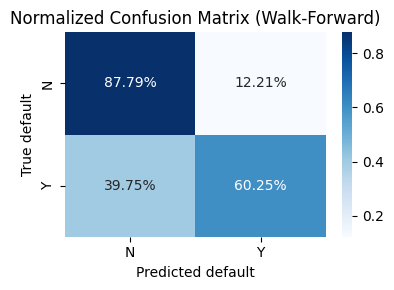

In [324]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", )
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm / cm.sum(axis=1, keepdims=True),
    annot=True,
    fmt=".2%",
    cmap='Blues',
    xticklabels=encoders[target].classes_,
    yticklabels=encoders[target].classes_
)
plt.title("Normalized Confusion Matrix (Walk-Forward)")
plt.xlabel(f"Predicted {target}")
plt.ylabel(f"True {target}")
plt.tight_layout()
plt.show()

In [325]:
# Sensitivity/Recall, Precision, Specificity, etc. globally
TP = np.trace(cm)                     # sum of diagonal = correctly predicted
FP = cm.sum(axis=0) - np.diag(cm)     # false positives per predicted
FN = cm.sum(axis=1) - np.diag(cm)     # false negatives per actual
TN = cm.sum() - (TP + FP.sum() + FN.sum() - TP)  # total - all others

sensitivity = TP / (TP + FN.sum())    # overall recall
precision = TP / (TP + FP.sum())      # overall precision
specificity = TN / (TN + FP.sum())    # overall specificity
print(f"  Sensitivity / Recall: {sensitivity:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Specificity: {specificity:.3f}")

  Sensitivity / Recall: 0.827
  Precision: 0.827
  Specificity: 0.791


ROC AUC Score:  0.740227602590857


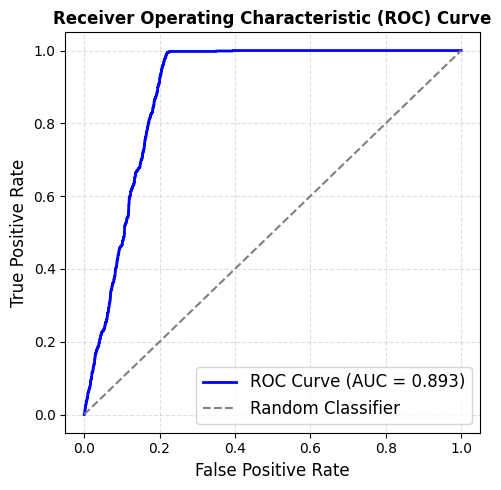

In [326]:
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

In [327]:
print(f"MSE (Probabilities vs True): {mean_squared_error(y_test, y_prob[:,1]):.4f}")

MSE (Probabilities vs True): 0.0959


<Figure size 1200x500 with 0 Axes>

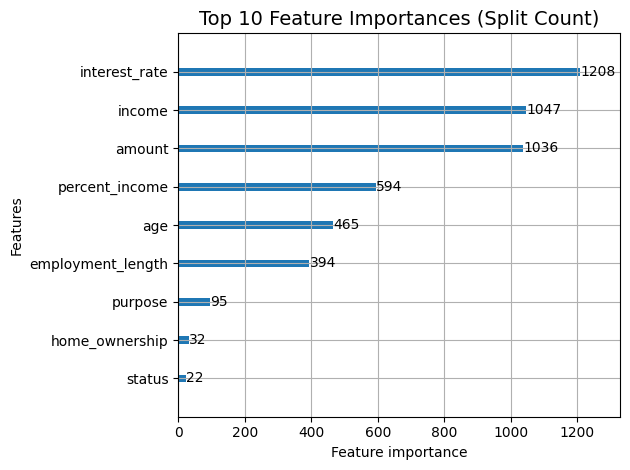

In [328]:
plt.figure(figsize=(12, 5))
lgb.plot_importance(model, max_num_features=10, importance_type='split')
plt.title("Top 10 Feature Importances (Split Count)", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

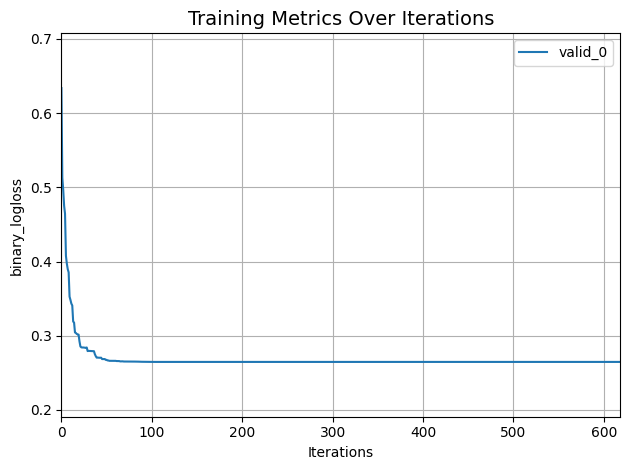

In [329]:
plt.figure(figsize=(8,5))
lgb.plot_metric(model)
plt.title("Training Metrics Over Iterations", fontsize=14)
plt.tight_layout()
plt.show()

In [330]:
print(model.booster_.dump_model()["tree_info"][0])

{'tree_index': 0, 'num_leaves': 251, 'num_cat': 0, 'shrinkage': 0.271465, 'tree_structure': {'split_index': 0, 'split_feature': 7, 'split_gain': 1327.300048828125, 'threshold': 1.0000000180025095e-35, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 0.000289163, 'internal_weight': 7979.75, 'internal_count': 31919, 'left_child': {'split_index': 1, 'split_feature': 3, 'split_gain': 213.58099365234375, 'threshold': -0.799947345242623, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.067001, 'internal_weight': 5821.25, 'internal_count': 23285, 'left_child': {'split_index': 33, 'split_feature': 1, 'split_gain': 15.260499954223633, 'threshold': 0.24387569198838324, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.227138, 'internal_weight': 536, 'internal_count': 2144, 'left_child': {'split_index': 46, 'split_feature': 1, 'split_gain': 5.18110990524292, 'threshold': -0.85360

In [331]:
def pretty_tree(node, prefix=""):
    if "leaf_value" in node:
        print(prefix + Fore.GREEN + f"◆ Leaf: value = {node['leaf_value']:.5f}" + Style.RESET_ALL)
        return
    feature = node["split_feature"]
    threshold = node["threshold"]
    print(prefix + Fore.CYAN + f"● Feature[{feature}] <= {threshold}" + Style.RESET_ALL)
    left_prefix  = prefix + "   │ "
    right_prefix = prefix + "   │ "
    print(prefix + "   ├── " + Fore.YELLOW + "Left:" + Style.RESET_ALL)
    pretty_tree(node["left_child"], prefix + "   │    ")
    print(prefix + "   └── " + Fore.YELLOW + "Right:" + Style.RESET_ALL)
    pretty_tree(node["right_child"], prefix + "        ")

tree = model.booster_.dump_model()["tree_info"][0]["tree_structure"]
pretty_tree(tree)

● Feature[7] <= 1.0000000180025095e-35
   ├── Left:
   │    ● Feature[3] <= -0.799947345242623
   │       ├── Left:
   │       │    ● Feature[1] <= 0.24387569198838324
   │       │       ├── Left:
   │       │       │    ● Feature[1] <= -0.8536097560975608
   │       │       │       ├── Left:
   │       │       │       │    ◆ Leaf: value = -0.30159
   │       │       │       └── Right:
   │       │       │            ● Feature[1] <= -0.12268108388786418
   │       │       │               ├── Left:
   │       │       │               │    ● Feature[1] <= -0.3169414965076223
   │       │       │               │       ├── Left:
   │       │       │               │       │    ● Feature[1] <= -0.3679837209920808
   │       │       │               │       │       ├── Left:
   │       │       │               │       │       │    ● Feature[1] <= -0.41463073317846616
   │       │       │               │       │       │       ├── Left:
   │       │       │               │       │       │       │ 

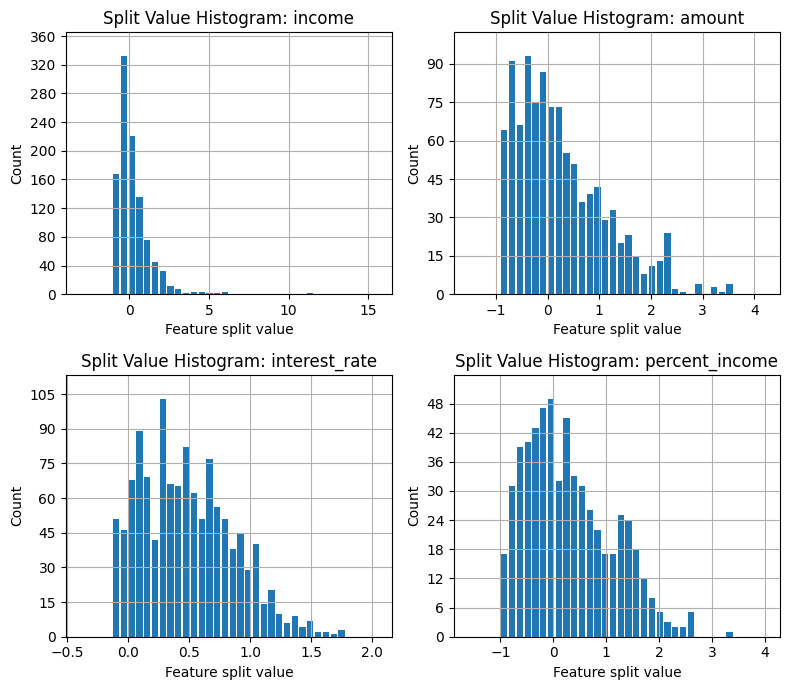

In [332]:
to_plot_features = ["income", "amount", "interest_rate", "percent_income"] # 4 most important continuous features
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes = axes.ravel()  # flatten to 1D iterator
for ax, feat in zip(axes, to_plot_features):
    lgb.plot_split_value_histogram(model, feature=feat, bins=30, ax=ax)
    ax.set_title(f"Split Value Histogram: {feat}", fontsize=12)
plt.tight_layout()
plt.show()

In [333]:
joblib.dump(model, "data/credit_risk_model/model.jb")
joblib.dump(encoders, "data/credit_risk_model/label_encoders.jb")
joblib.dump(scalers, "data/credit_risk_model/scalers_encoder.jb")

['data/credit_risk_model/scalers_encoder.jb']